# Import libraries

In [1]:
# 0. Import

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import celloracle as co
co.__version__

# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# Load data

In [2]:
adata = sc.read_h5ad("fib_par2.h5ad")
adata

AnnData object with n_obs × n_vars = 6038 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Source', 'Tissue', 'Origin', 'percent.mt', 'percent.heat', 'percent.dissociation', 'percent.ribo', 'mRNA.catabolic', 'ribonuclease.activity', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'RNA_snn_res.1', 'seurat_clusters', 'RNA_snn_res.0.2', 'RNA_snn_res.0.4', 'RNA_snn_res.0.6', 'RNA_snn_res.0.8', 'RNA_snn_res.1.2', 'RNA_snn_res.1.4', 'RNA_snn_res.1.6', 'RNA_snn_res.1.8', 'RNA_snn_res.2', 'Metastasis', 'VDJ', 'IGHC', 'Drainage', 'Origin2', 'Origin3', 'Metastasis_n', 'Origin2_n', 'level_1', 'level_2', 'level_3', 'Origin4', 'Metastatic', 'Pseudotime', 'n_counts_all', 'n_counts'
    var: 'name', 'n_counts', 'mean', 'std'
    uns: 'diffmap_evals', 'draw_graph', 'level_3_colors', 'level_3_sizes', 'neighbors', 'paga', 'pca'
    obsm: 'X_diffmap', 'X_dm', 'X_draw_graph_fa', 'X_dt', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities',

In [3]:
print(f"Cell number is :{adata.shape[0]}")
print(f"Gene number is :{adata.shape[1]}")

Cell number is :6038
Gene number is :2000


In [4]:
# Load TF info which was made from mouse cell atlas dataset.
base_GRN = co.data.load_human_promoter_base_GRN(version="hg38_gimmemotifsv5_fpr2")

# Check data
base_GRN.head()
#base_GRN.to_csv('test.csv')

Loading prebuilt promoter base-GRN. Version: hg38_gimmemotifsv5_fpr2


,peak_id,gene_short_name,9430076C15RIK,AC002126.6,AC012531.1,AC226150.2,AFP,AHR,AHRR,AIRE,...,ZNF784,ZNF8,ZNF816,ZNF85,ZSCAN10,ZSCAN16,ZSCAN22,ZSCAN26,ZSCAN31,ZSCAN4
0,chr10_100009853_100010953,DNMBP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_100081785_100082885,CPN1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,chr10_100185877_100186977,ERLIN1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr10_100186978_100187057,ERLIN1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_100229510_100230610,CHUK,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Make Oracle object

In [5]:
# Instantiate Oracle object
oracle = co.Oracle()

In [6]:
# Check data in anndata
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Metadata columns : ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Source', 'Tissue', 'Origin', 'percent.mt', 'percent.heat', 'percent.dissociation', 'percent.ribo', 'mRNA.catabolic', 'ribonuclease.activity', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'RNA_snn_res.1', 'seurat_clusters', 'RNA_snn_res.0.2', 'RNA_snn_res.0.4', 'RNA_snn_res.0.6', 'RNA_snn_res.0.8', 'RNA_snn_res.1.2', 'RNA_snn_res.1.4', 'RNA_snn_res.1.6', 'RNA_snn_res.1.8', 'RNA_snn_res.2', 'Metastasis', 'VDJ', 'IGHC', 'Drainage', 'Origin2', 'Origin3', 'Metastasis_n', 'Origin2_n', 'level_1', 'level_2', 'level_3', 'Origin4', 'Metastatic', 'Pseudotime', 'n_counts_all', 'n_counts']
Dimensional reduction:  ['X_diffmap', 'X_dm', 'X_draw_graph_fa', 'X_dt', 'X_pca', 'X_tsne', 'X_umap']


In [7]:
# In this notebook, we use the unscaled mRNA count for the nput of Oracle object.
adata.X = adata.layers["raw_count"].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="level_3",
                                   embedding_name="X_dt")

In [8]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

# KNN imputation

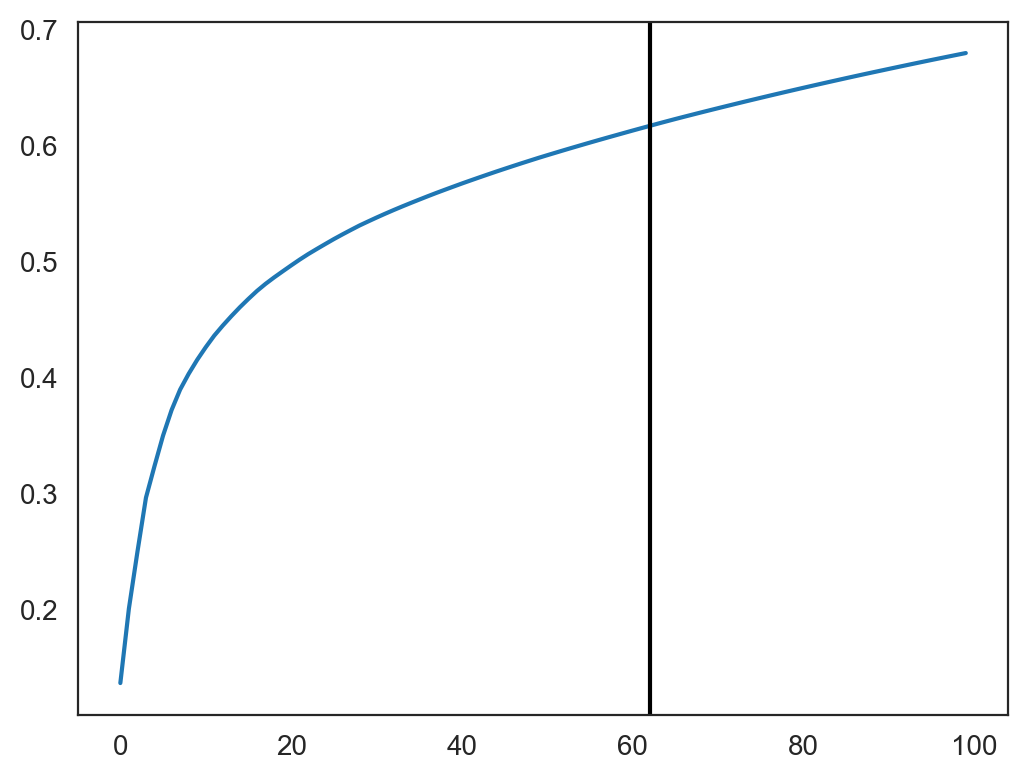

62


In [9]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [10]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :6038


In [11]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :150


In [12]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

# Save and Load

In [13]:
# Save oracle object.
oracle.to_hdf5("fib_par2.celloracle.oracle")

In [14]:
# Load file.
oracle = co.load_hdf5("fib_par2.celloracle.oracle")

# GRN calculation

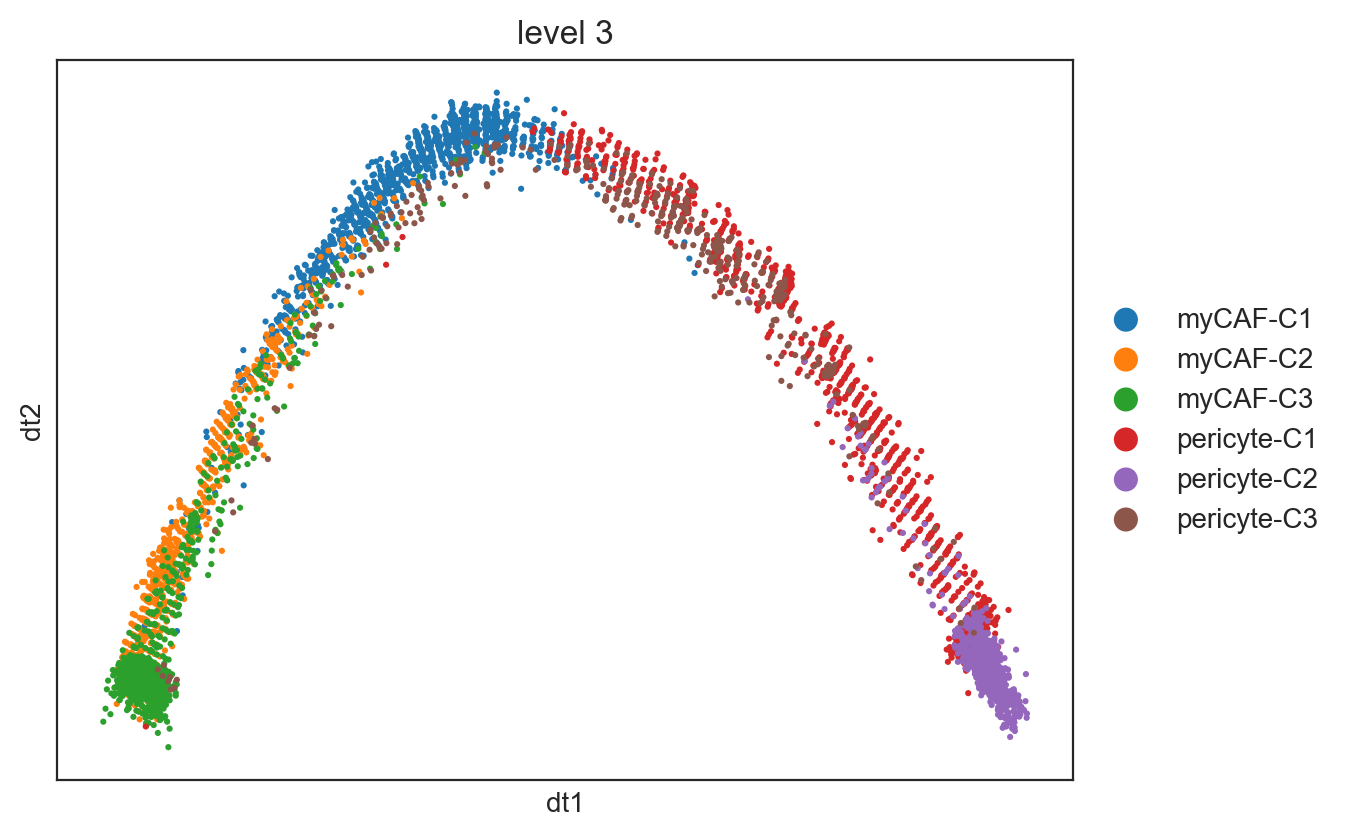

In [15]:
# Check clustering data
sc.pl.scatter(oracle.adata, color="level_3", basis="dt")

In [16]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.(~30 minutes)
links = oracle.get_links(cluster_name_for_GRN_unit="level_3", alpha=10,
                         verbose_level=10)

  0%|          | 0/6 [00:00<?, ?it/s]

Inferring GRN for myCAF-C1...


  0%|          | 0/1475 [00:00<?, ?it/s]

Inferring GRN for myCAF-C2...


  0%|          | 0/1475 [00:00<?, ?it/s]

Inferring GRN for myCAF-C3...


  0%|          | 0/1475 [00:00<?, ?it/s]

Inferring GRN for pericyte-C1...


  0%|          | 0/1475 [00:00<?, ?it/s]

Inferring GRN for pericyte-C2...


  0%|          | 0/1475 [00:00<?, ?it/s]

Inferring GRN for pericyte-C3...


  0%|          | 0/1475 [00:00<?, ?it/s]

CPU times: user 9min 45s, sys: 38.3 s, total: 10min 24s
Wall time: 10min 52s


# Network preprocessing

In [17]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

In [18]:
plt.rcParams["figure.figsize"] = [9, 4.5]

myCAF-C1


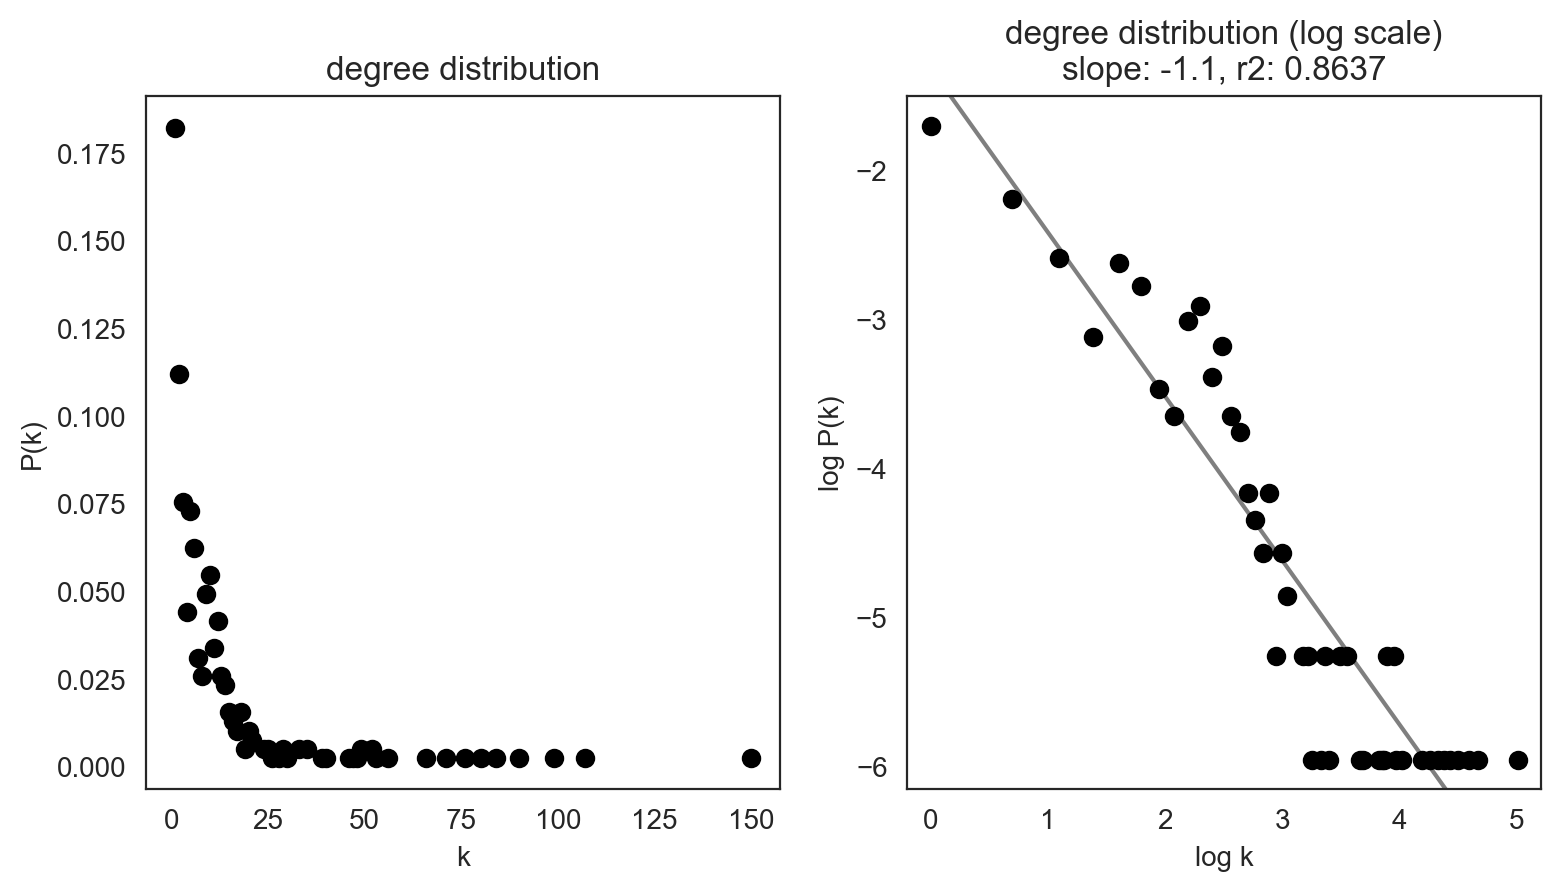

myCAF-C2


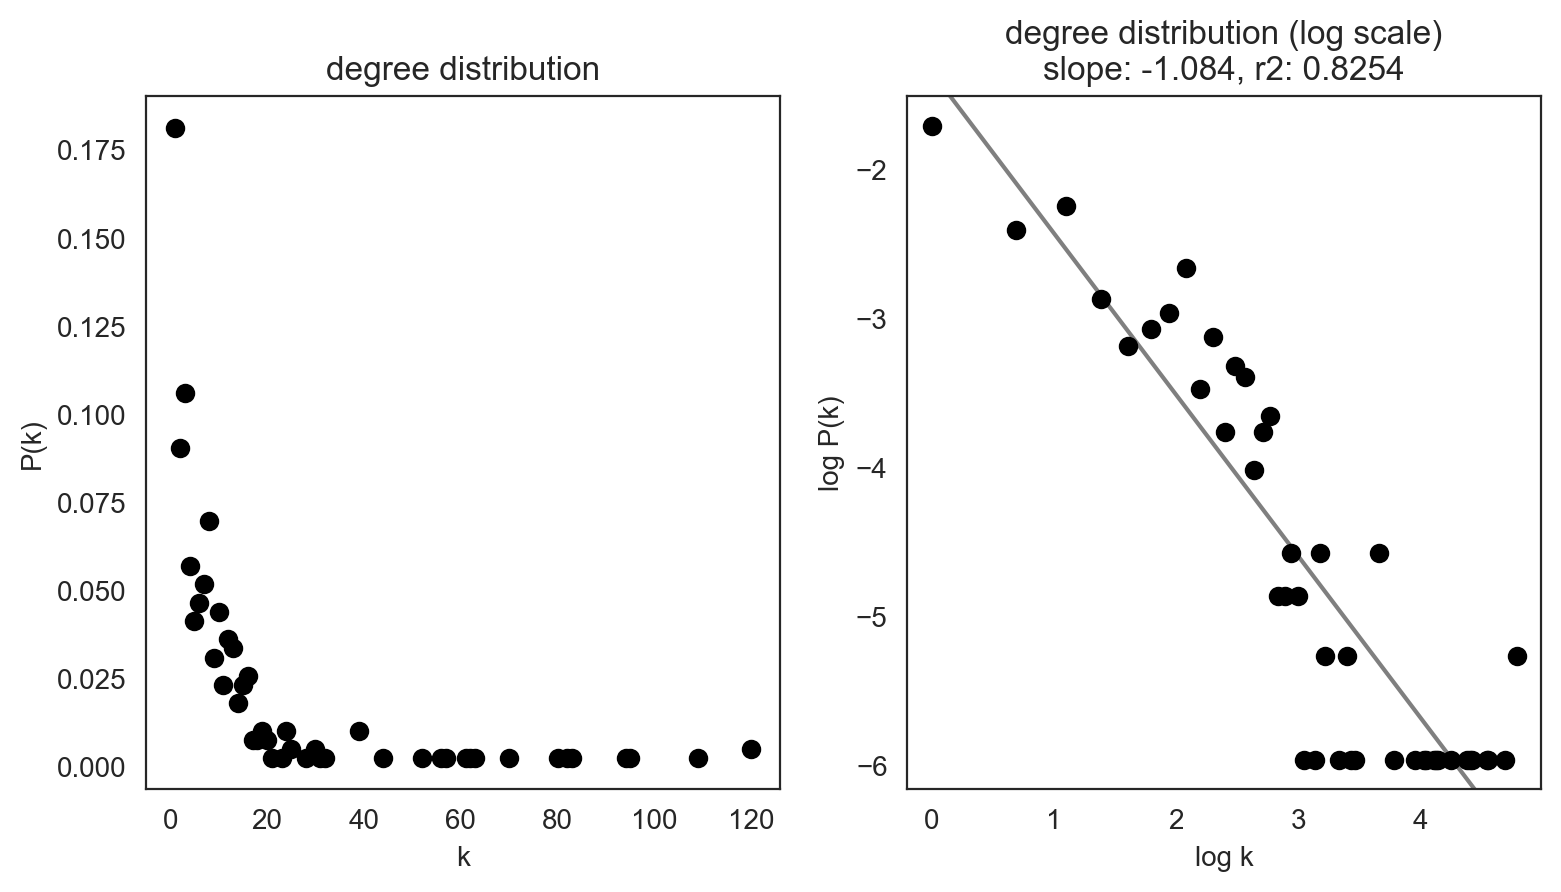

myCAF-C3


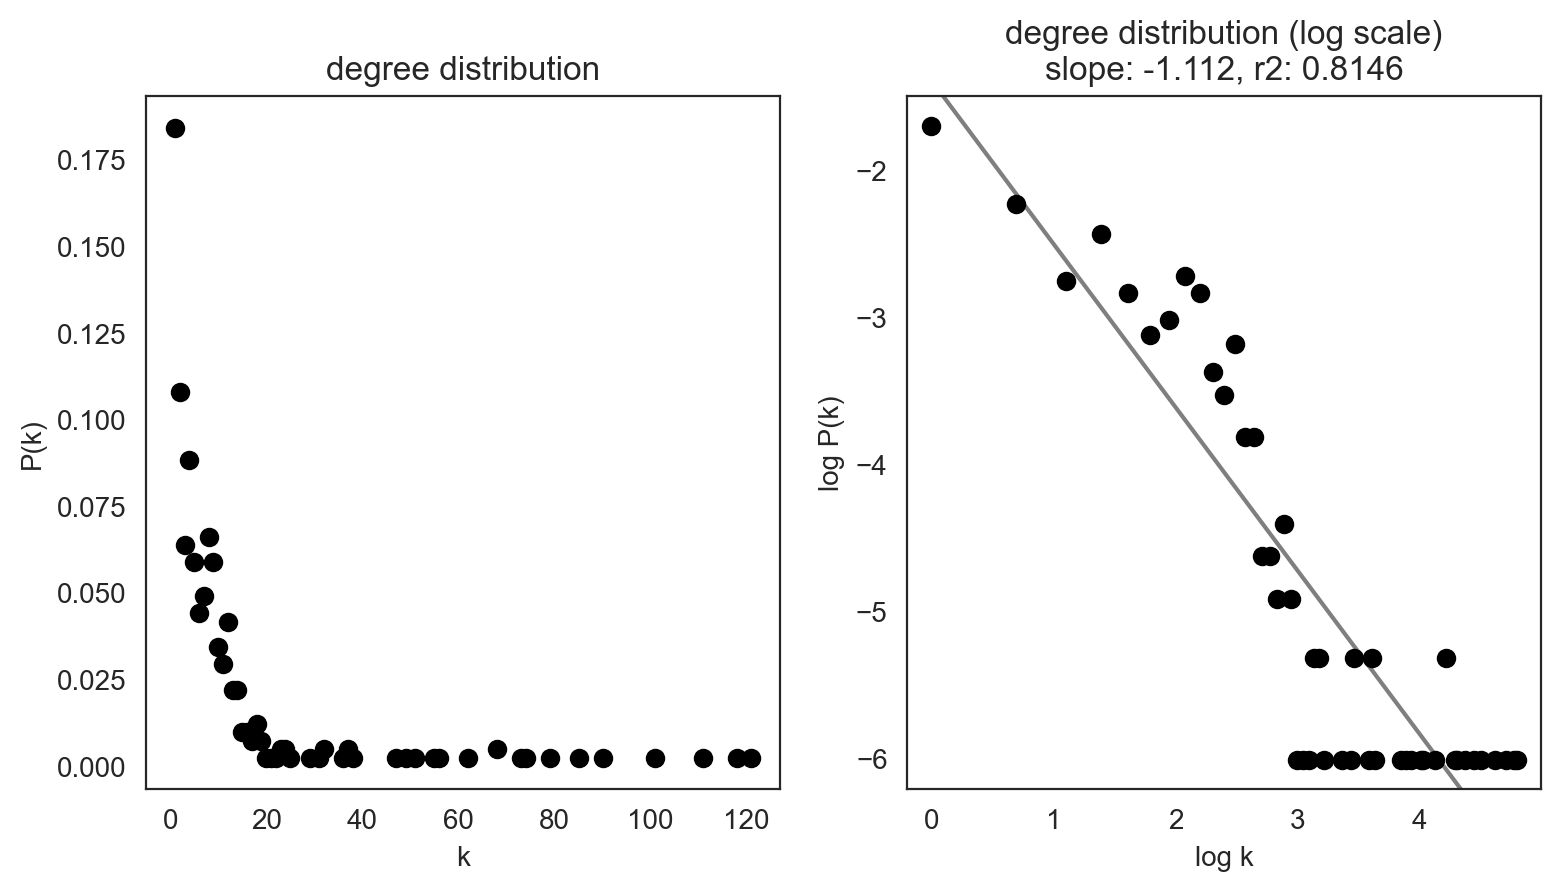

pericyte-C1


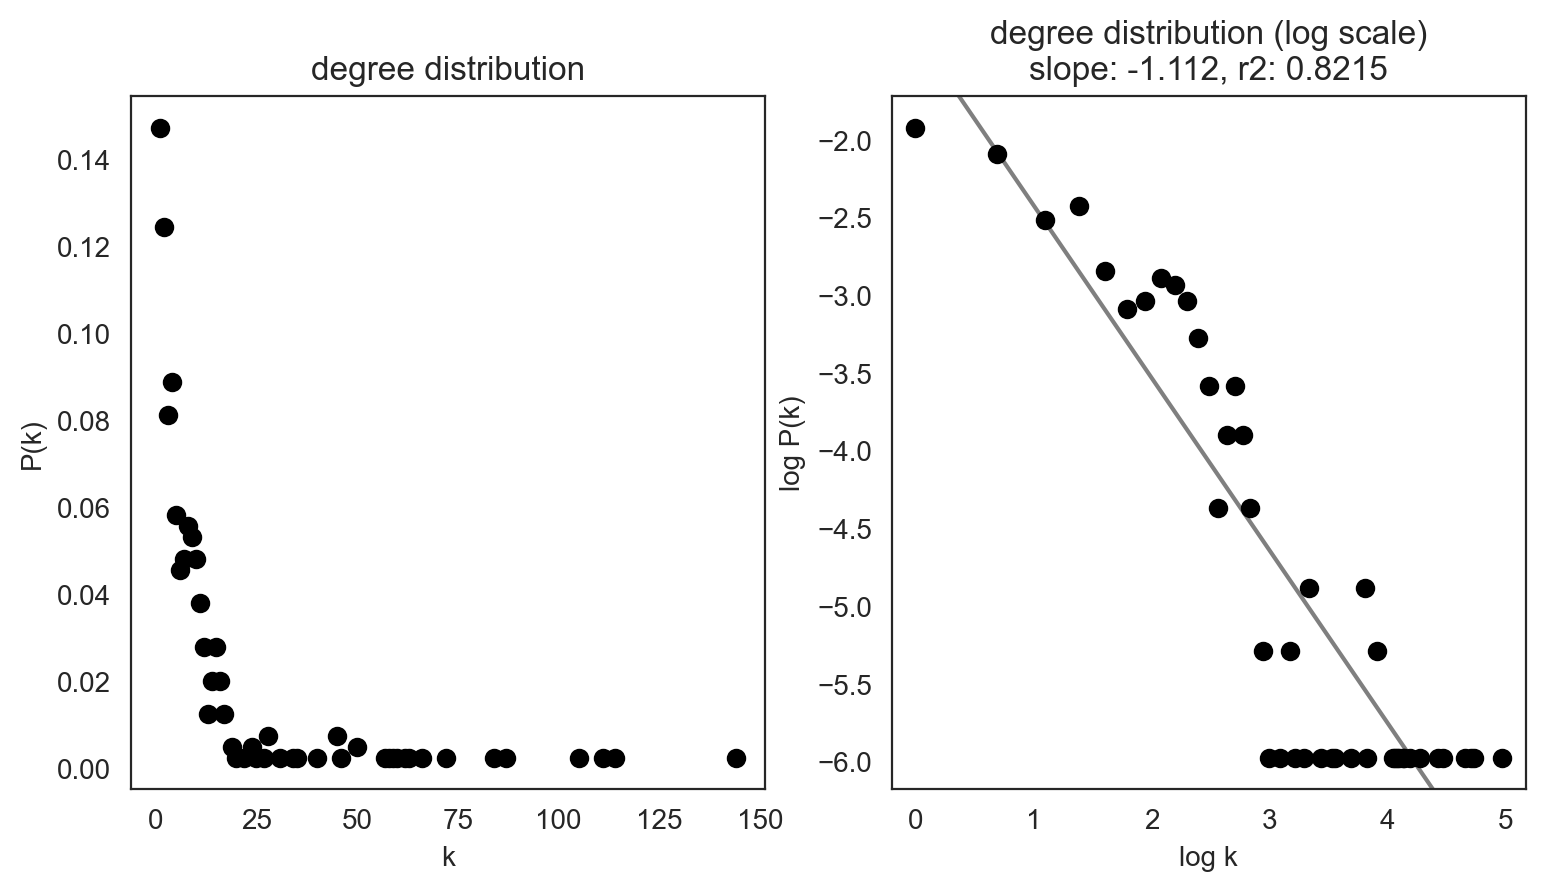

pericyte-C2


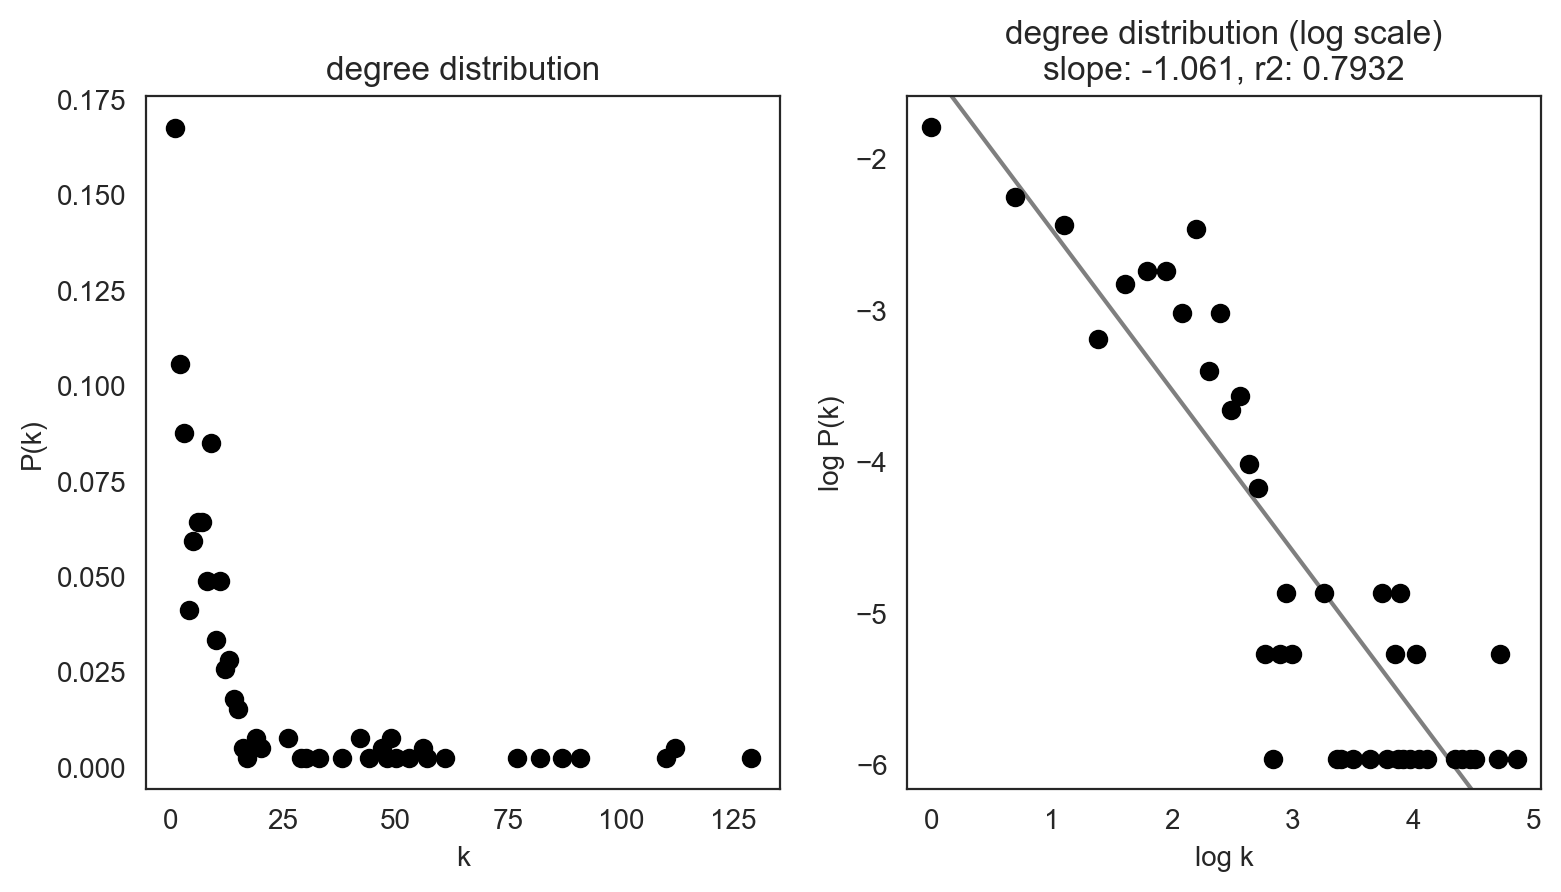

pericyte-C3


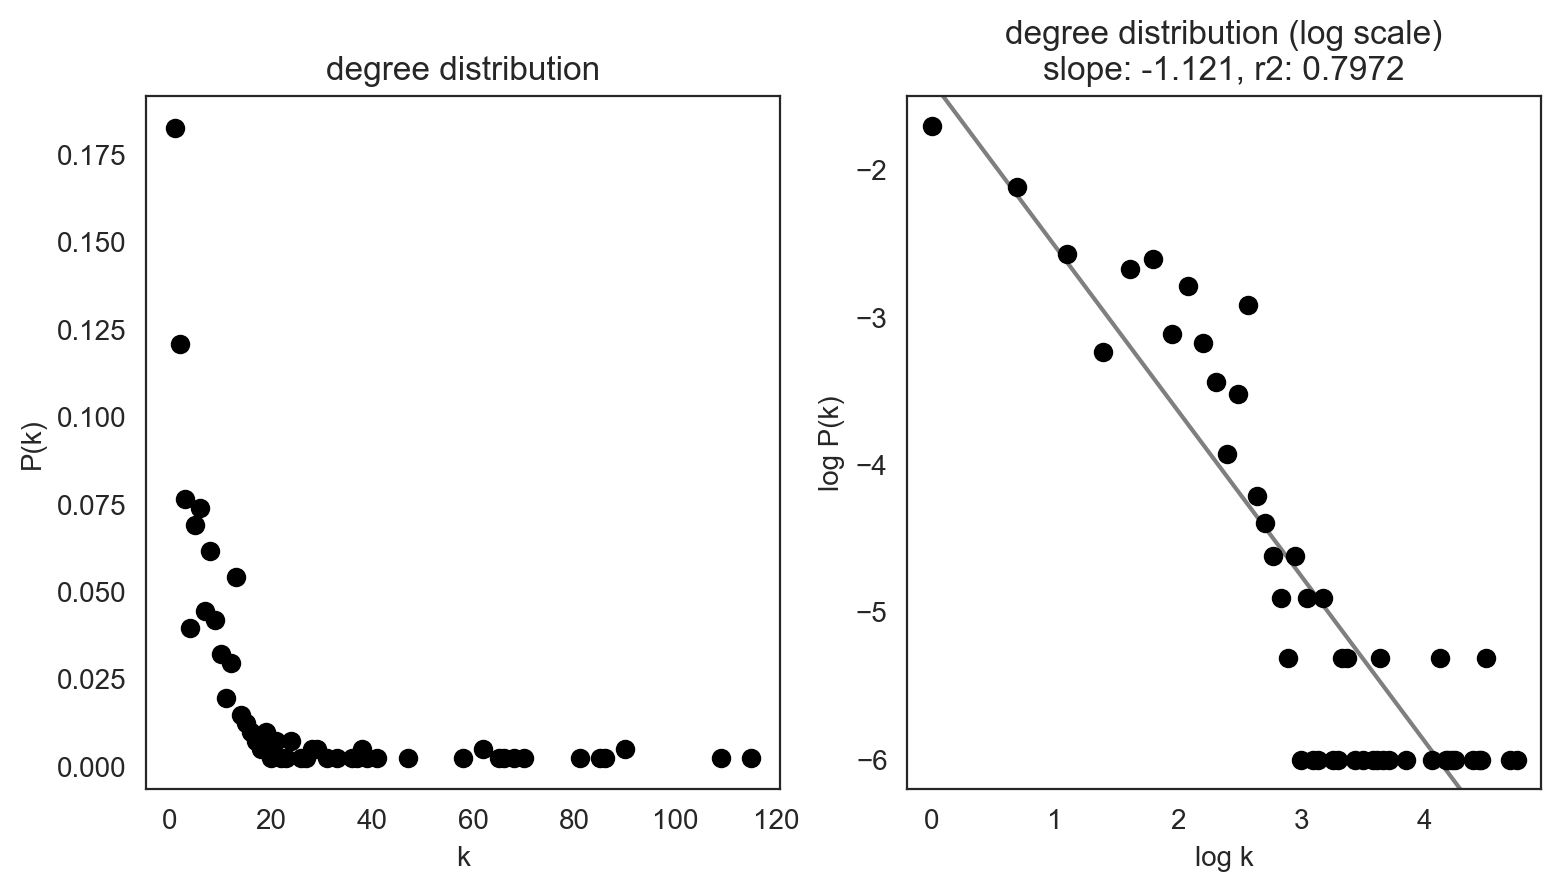

In [19]:
links.plot_degree_distributions(plot_model=True,
                                               #save=f"{save_folder}/degree_distribution/",
                                               )

In [20]:
plt.rcParams["figure.figsize"] = [10, 8]

In [21]:
# Calculate network scores.
links.get_network_score()

In [22]:
links.merged_score.head()

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
A2M,3,0.007833,3,0.007833,0,0.0,0.0,0.016769,myCAF-C1
ABCC9,4,0.010444,4,0.010444,0,0.0,0.0,0.015699,myCAF-C1
ABI3BP,3,0.007833,3,0.007833,0,0.0,0.0,0.006541,myCAF-C1
ACP5,2,0.005222,2,0.005222,0,0.0,0.0,0.002510,myCAF-C1
ACTA2,2,0.005222,2,0.005222,0,0.0,0.0,0.013479,myCAF-C1


In [23]:
# Save Links object.
links.to_hdf5(file_path="fib_par2.links.celloracle.links")

In [24]:
# You can load files with the following command.
links = co.load_hdf5(file_path="fib_par2.links.celloracle.links")

# Network analysis; Network score for each gene

In [25]:
# Check cluster name
links.cluster

['myCAF-C1',
 'myCAF-C2',
 'myCAF-C3',
 'pericyte-C1',
 'pericyte-C2',
 'pericyte-C3']

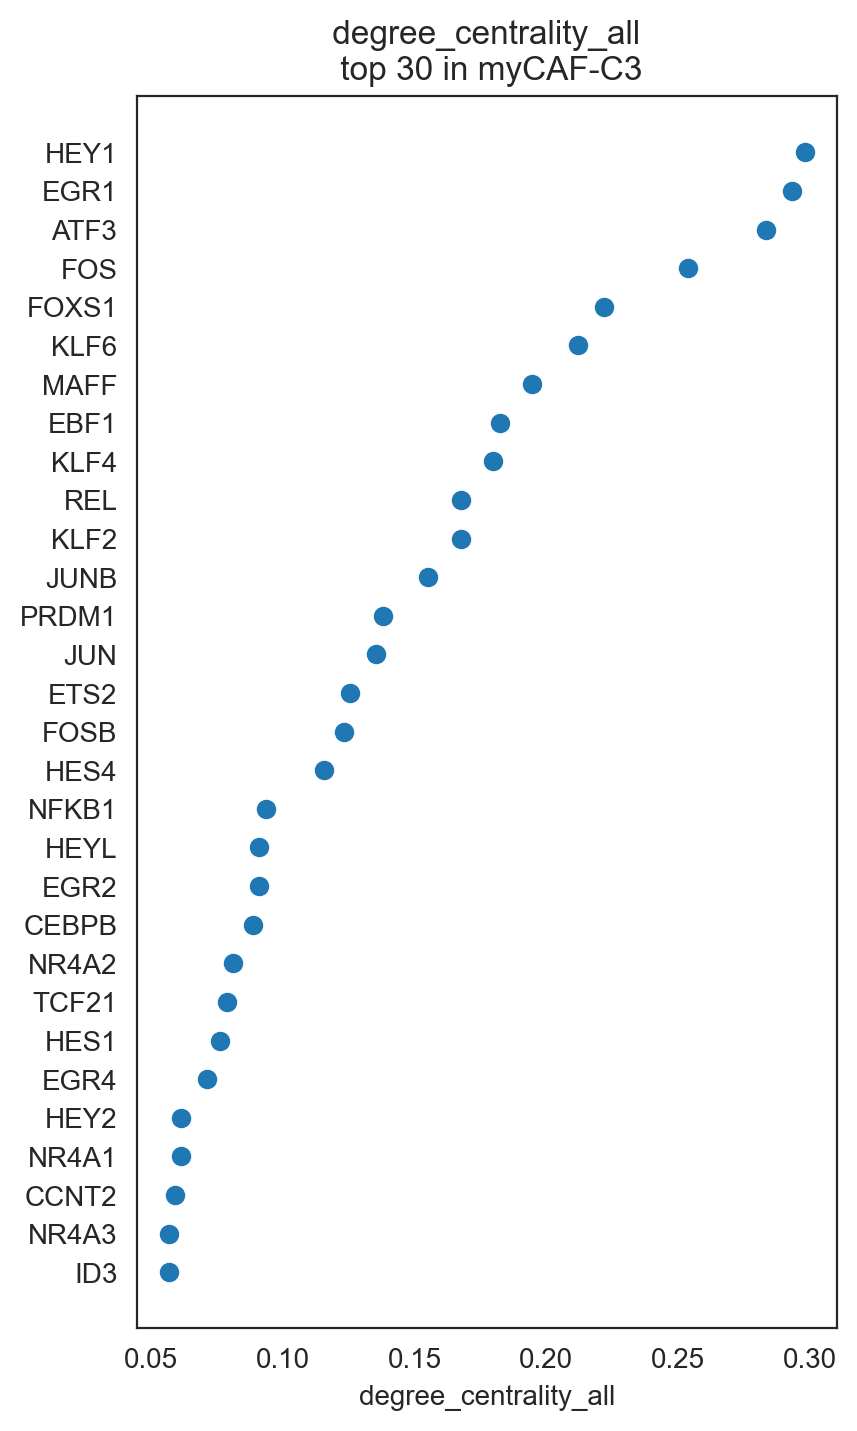

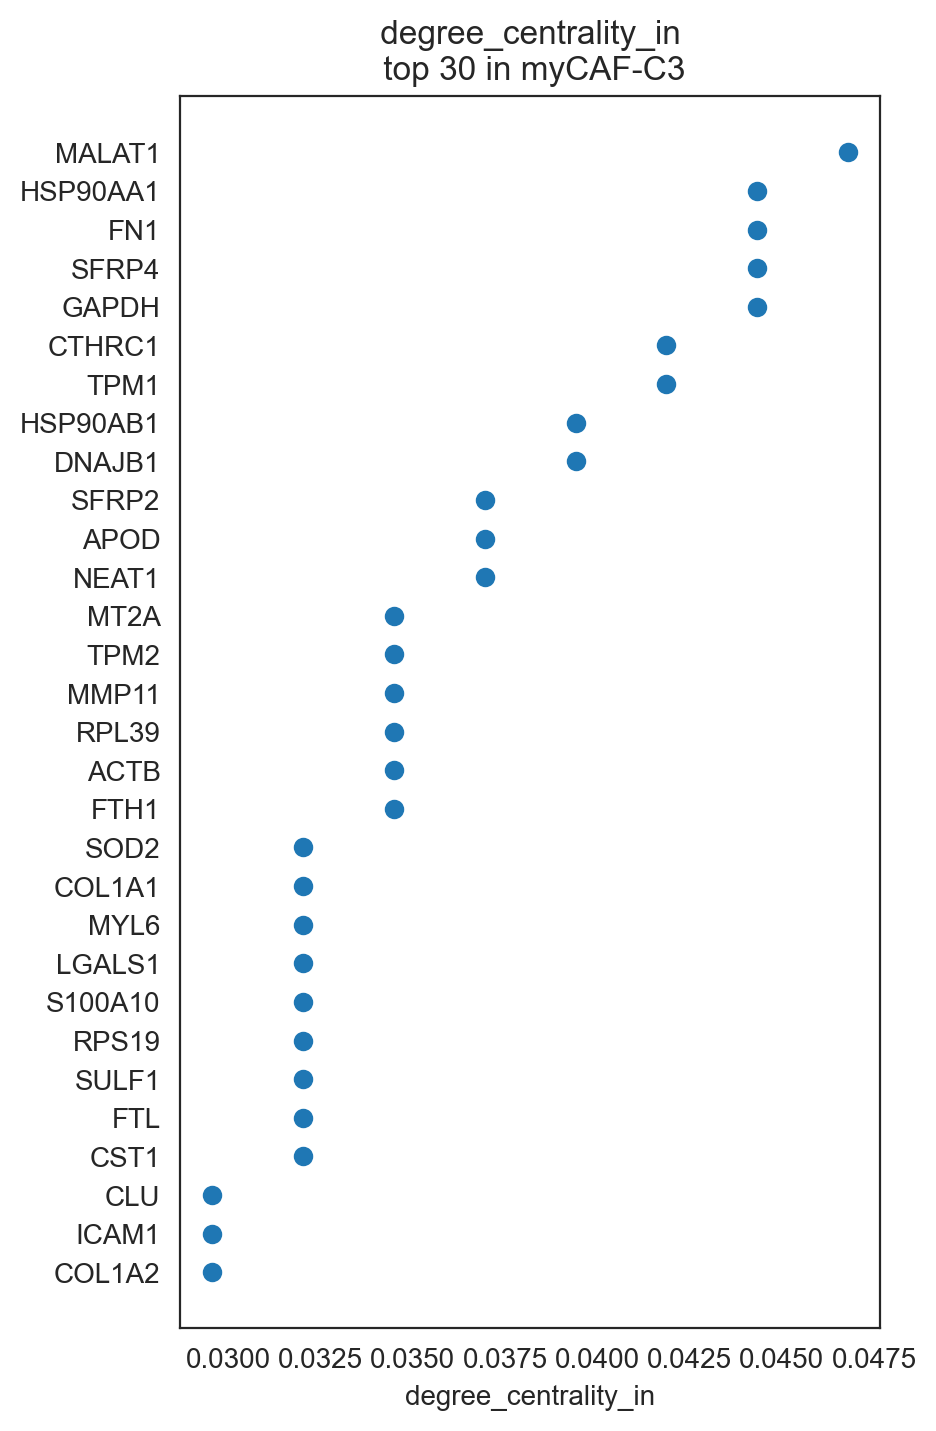

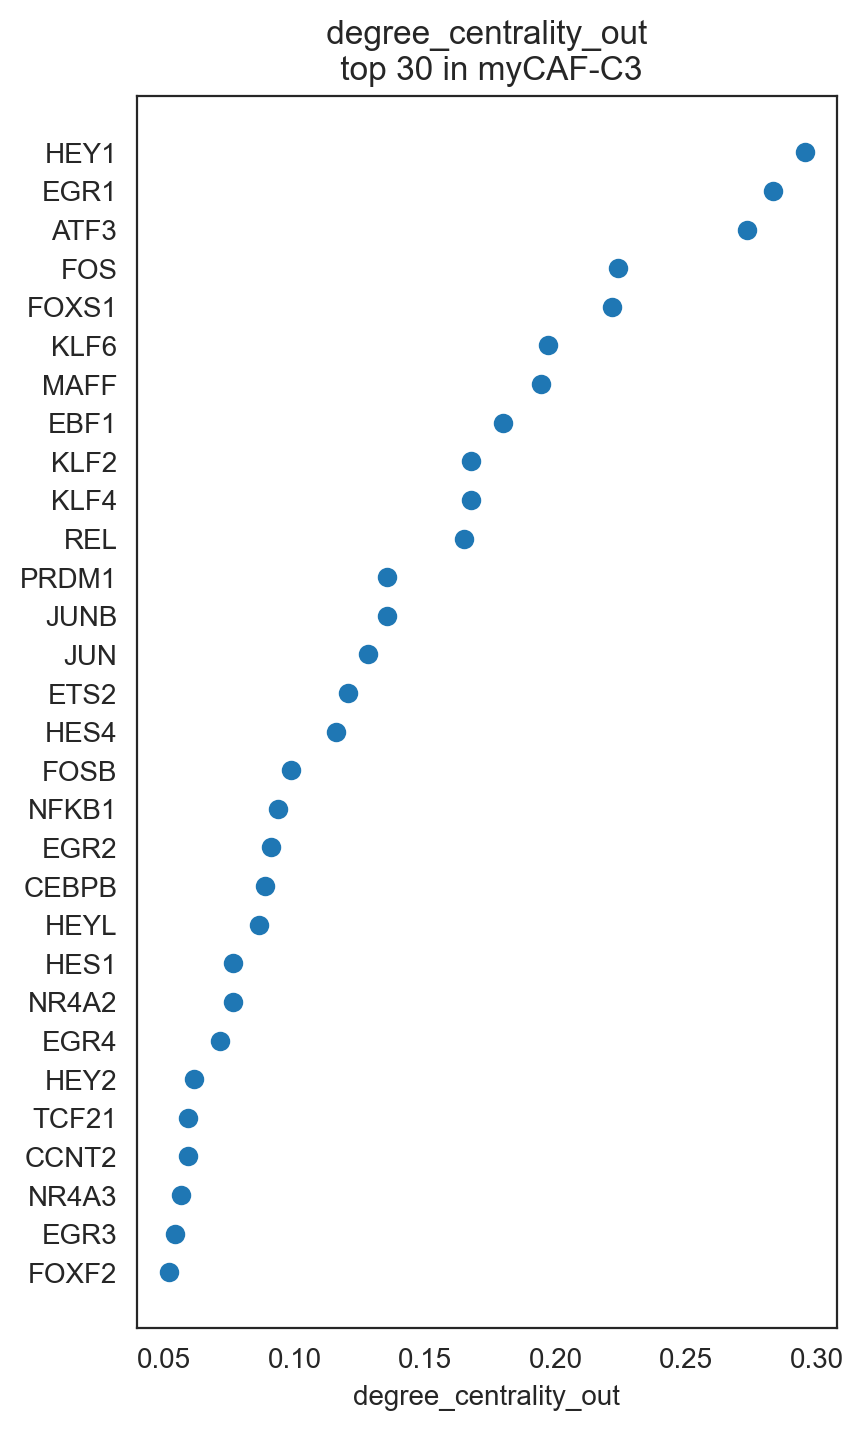

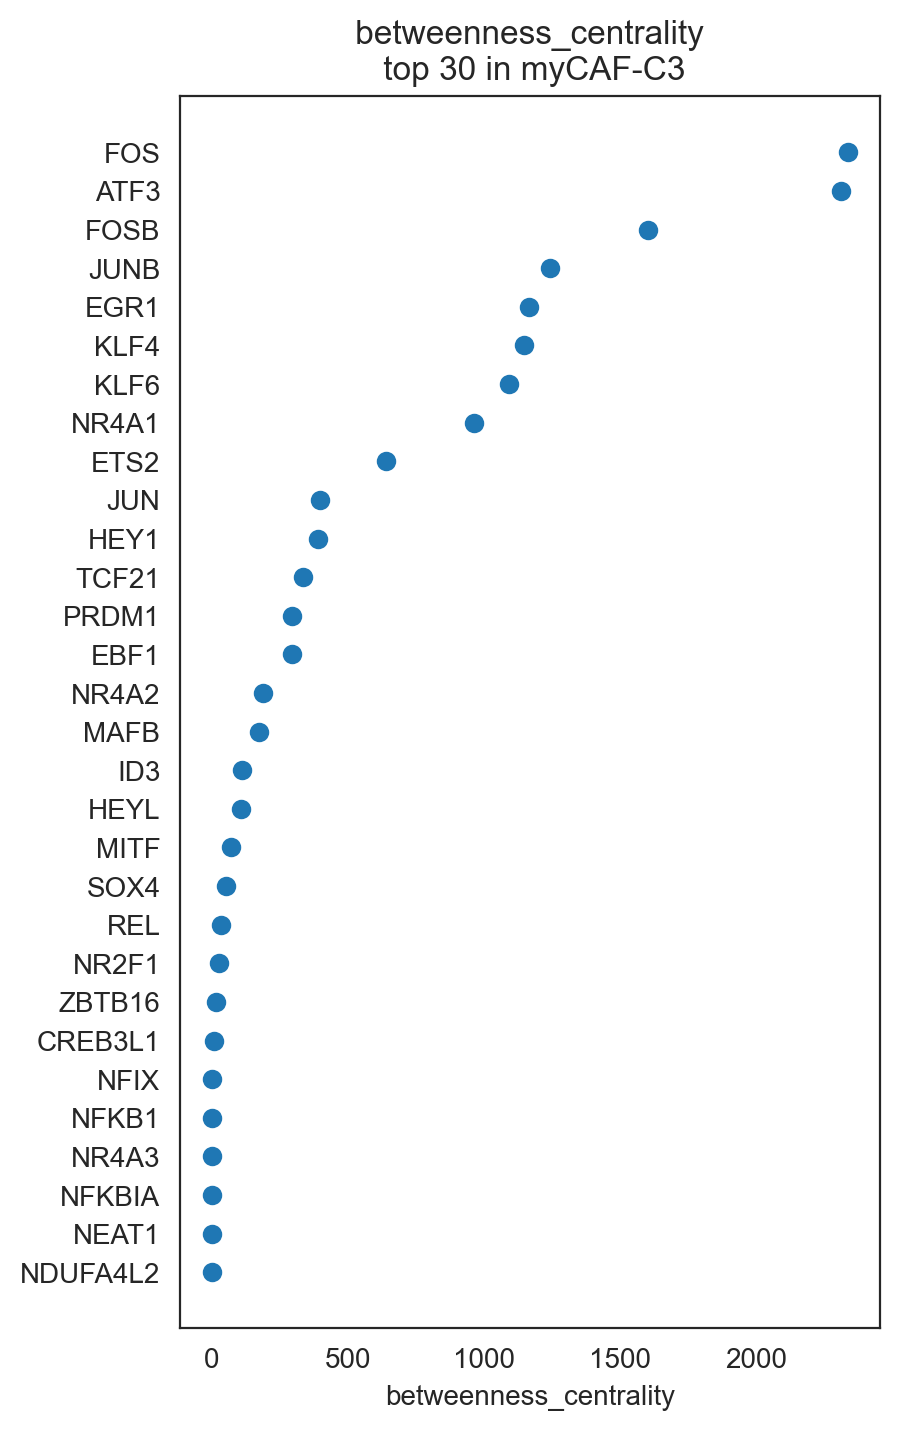

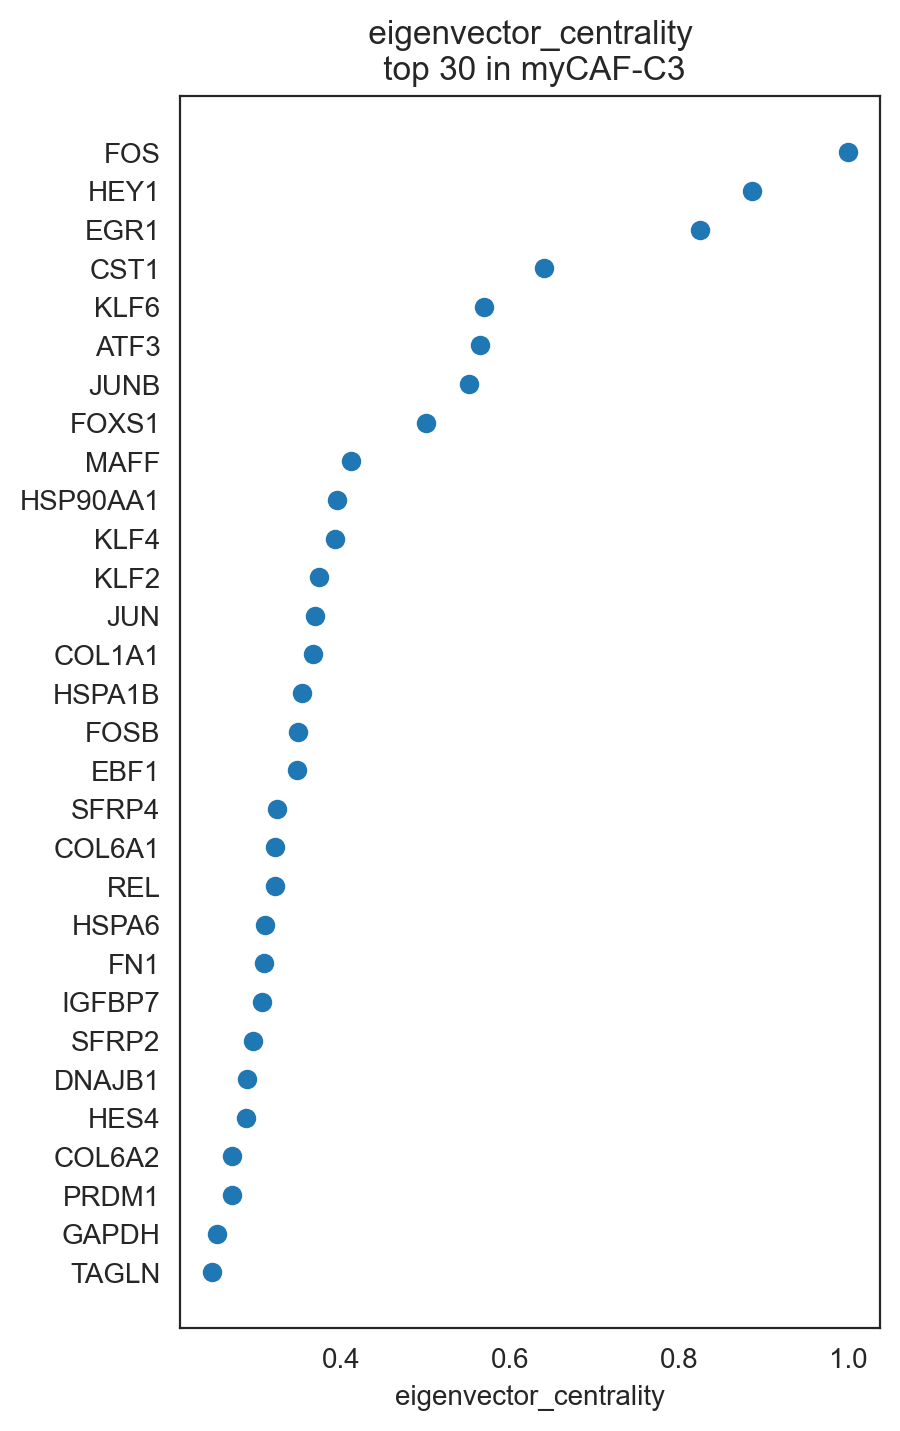

In [26]:
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="myCAF-C3", n_gene=30, save=f"{save_folder}/ranked_score")

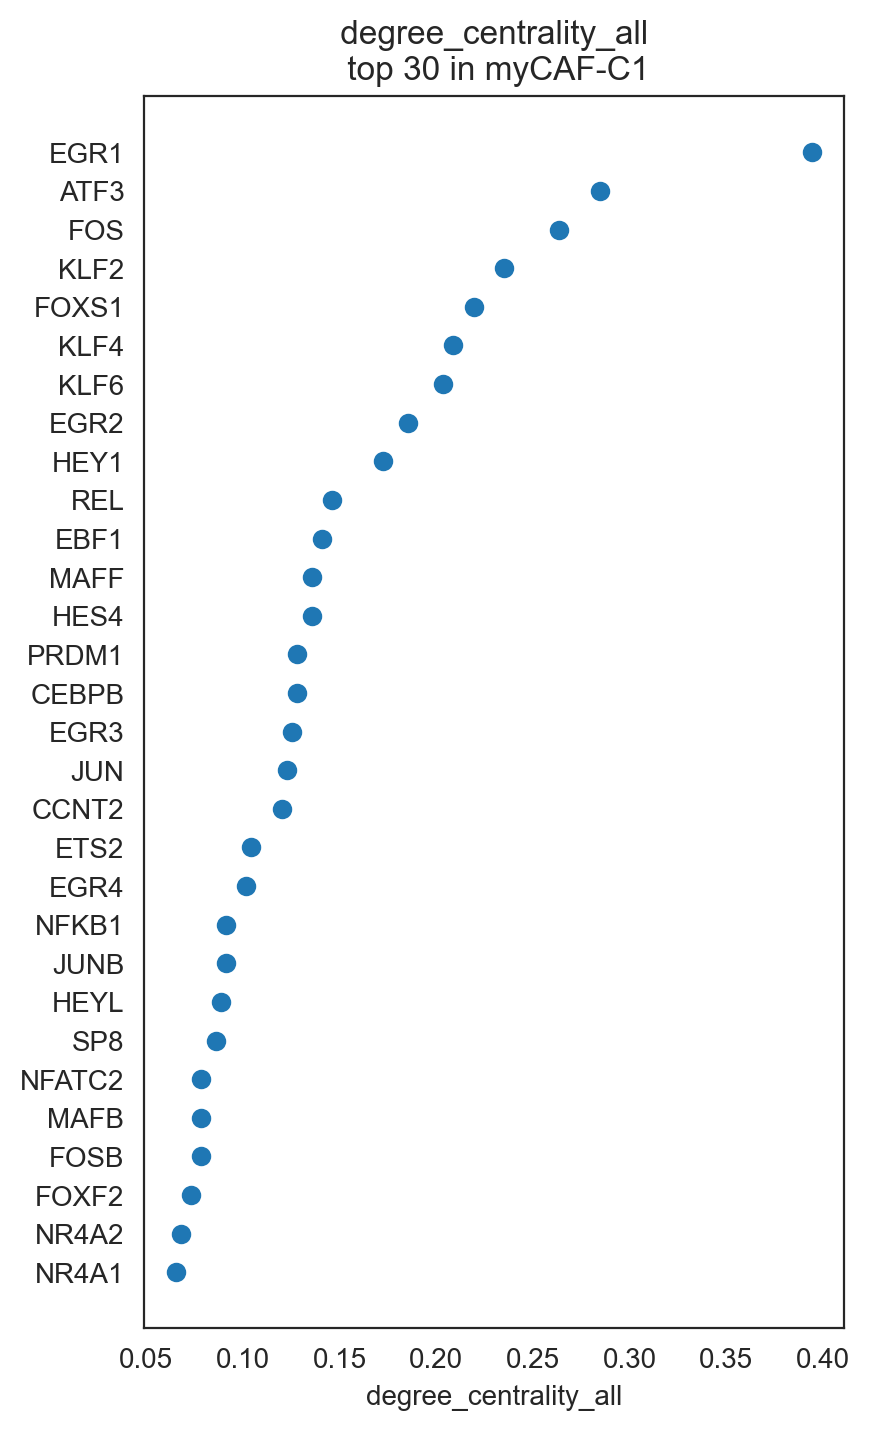

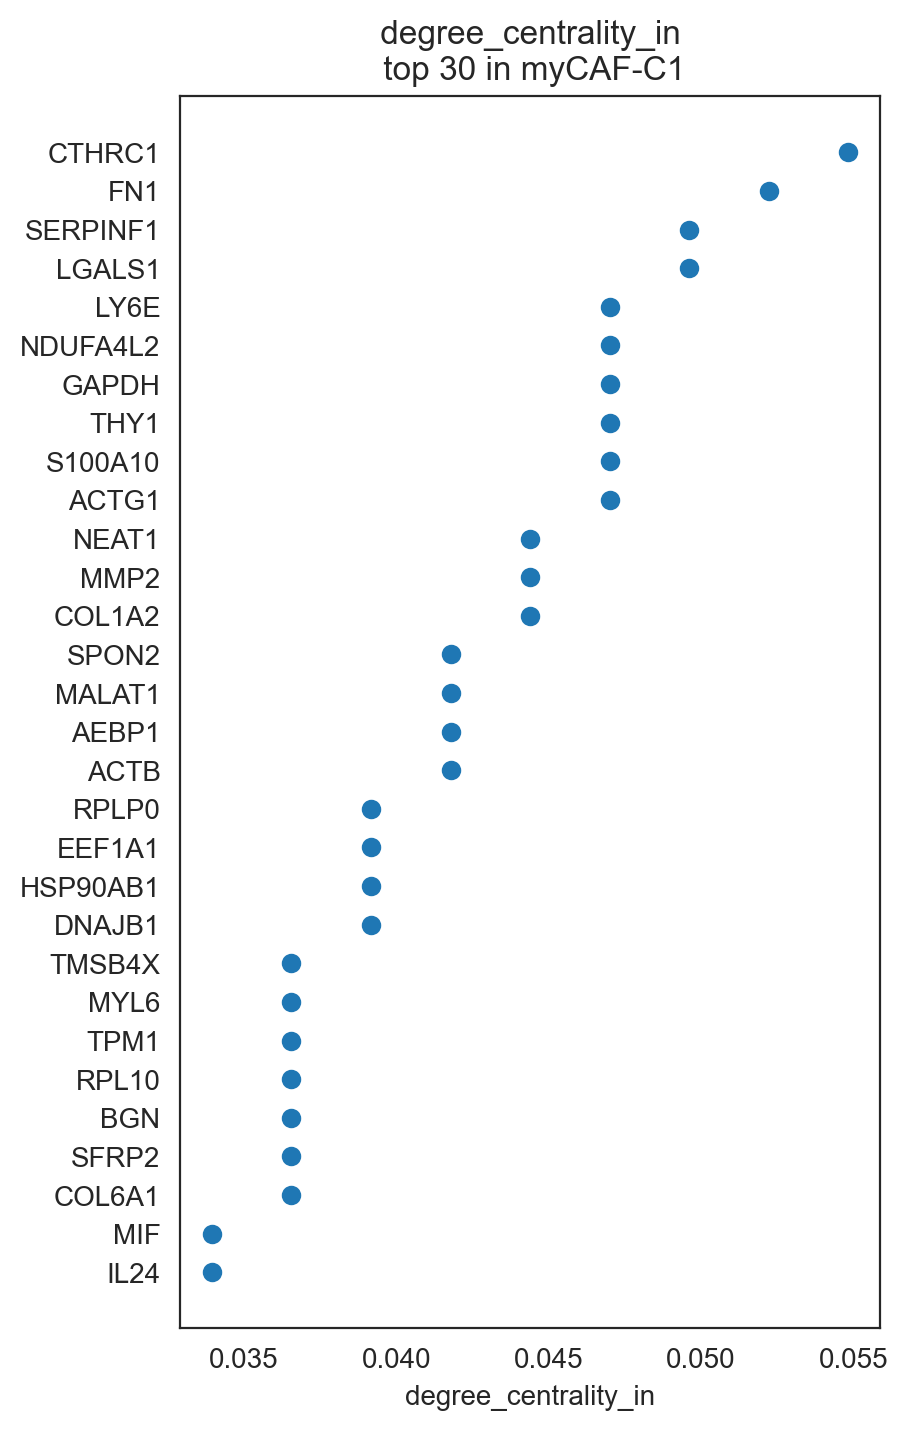

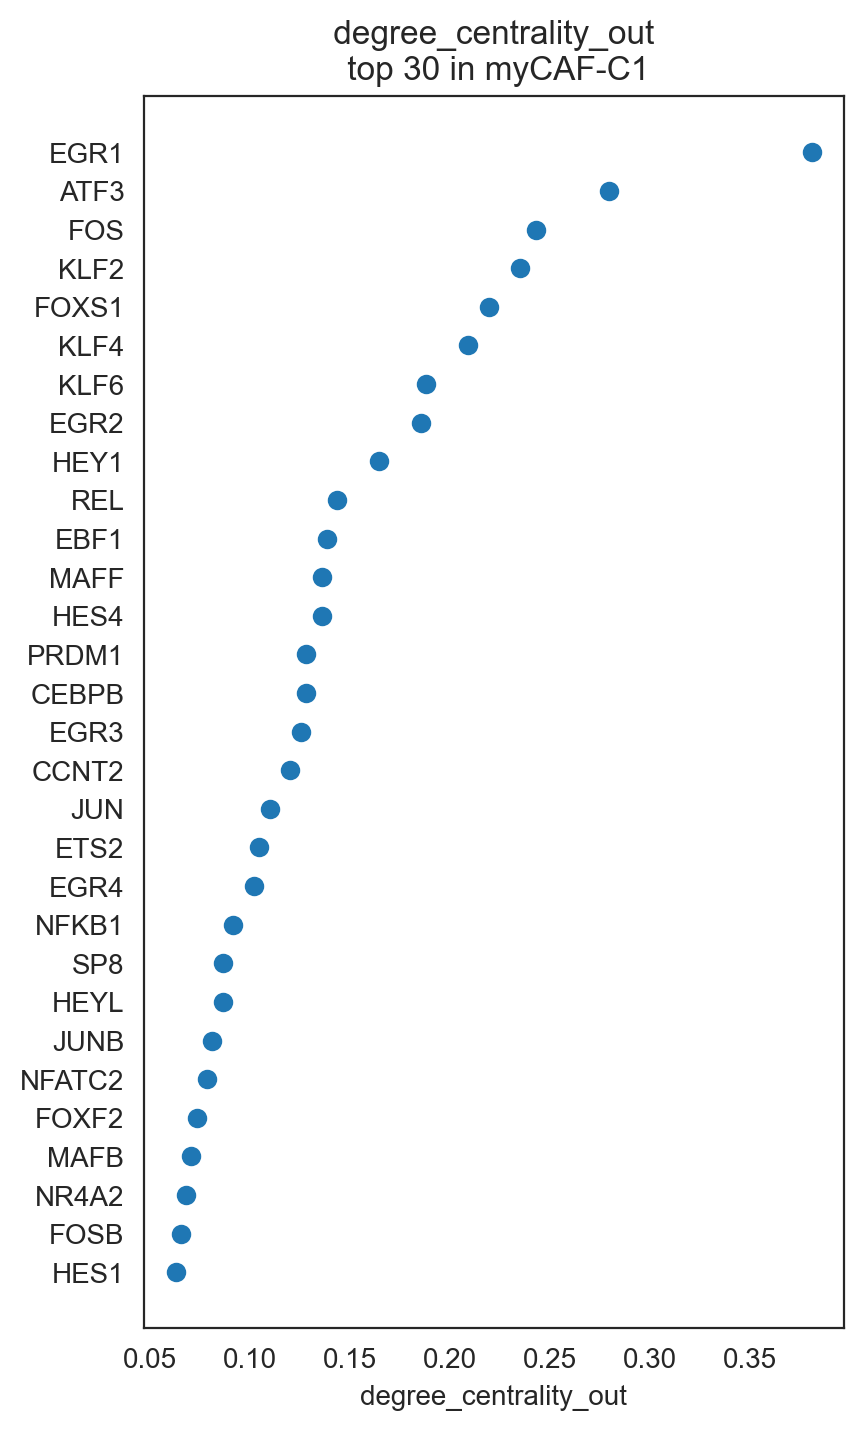

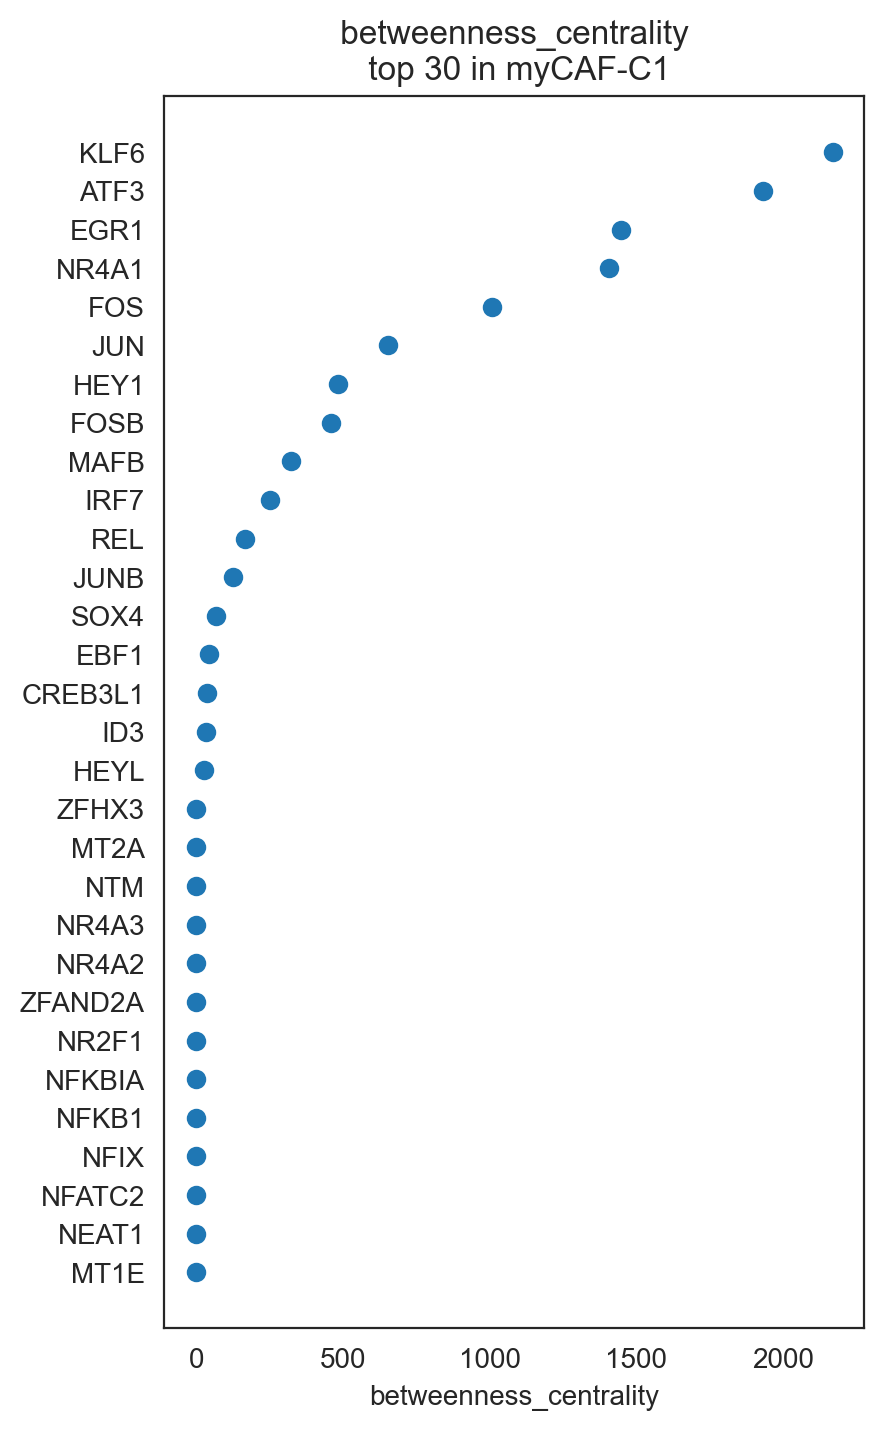

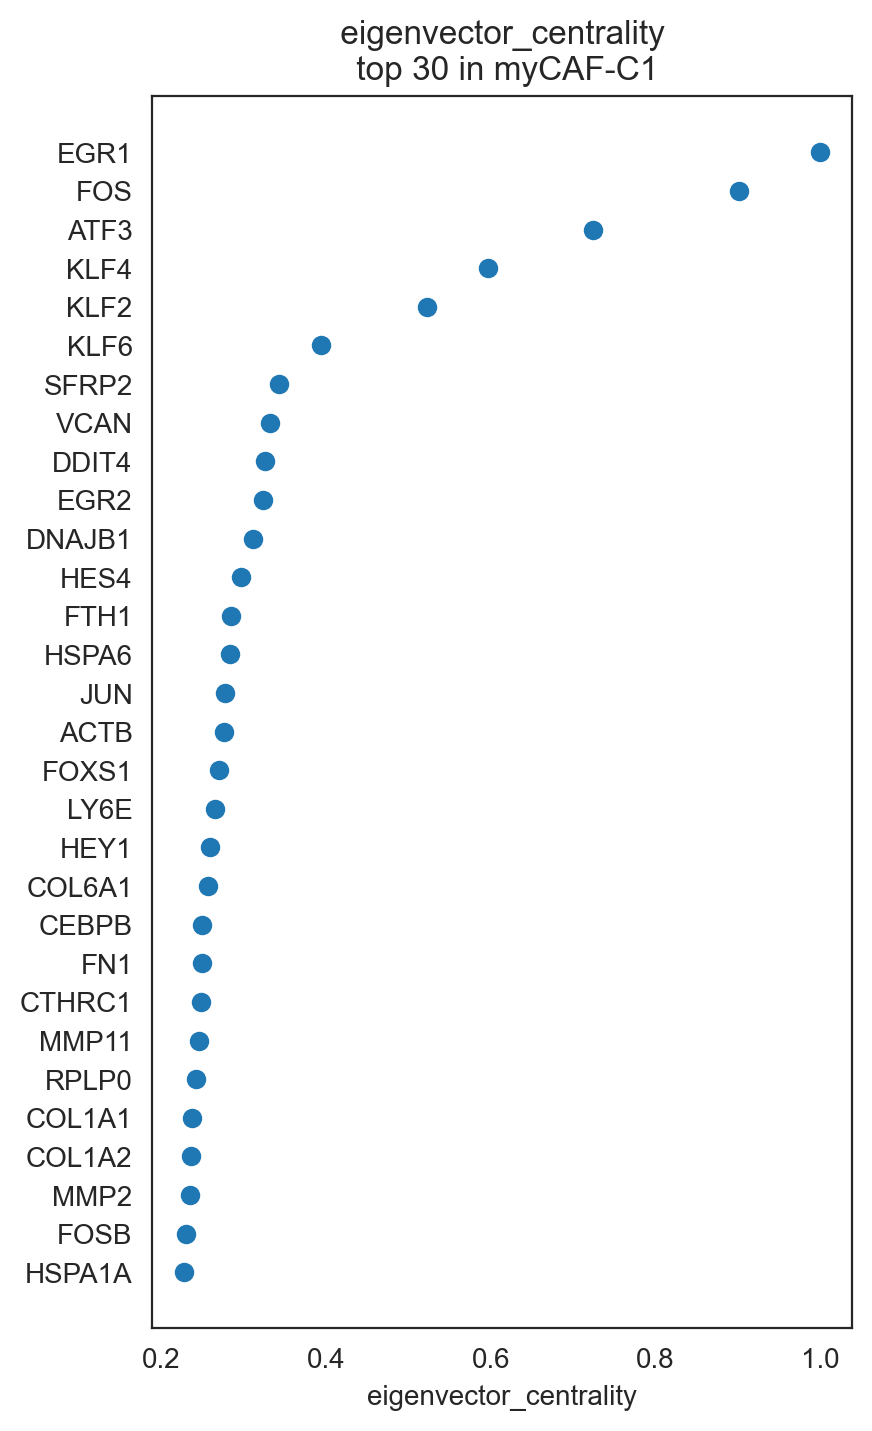

In [27]:
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="myCAF-C1", n_gene=30, save=f"{save_folder}/ranked_score")

By comparing network scores between two clusters, we can analyze differences in GRN structure.

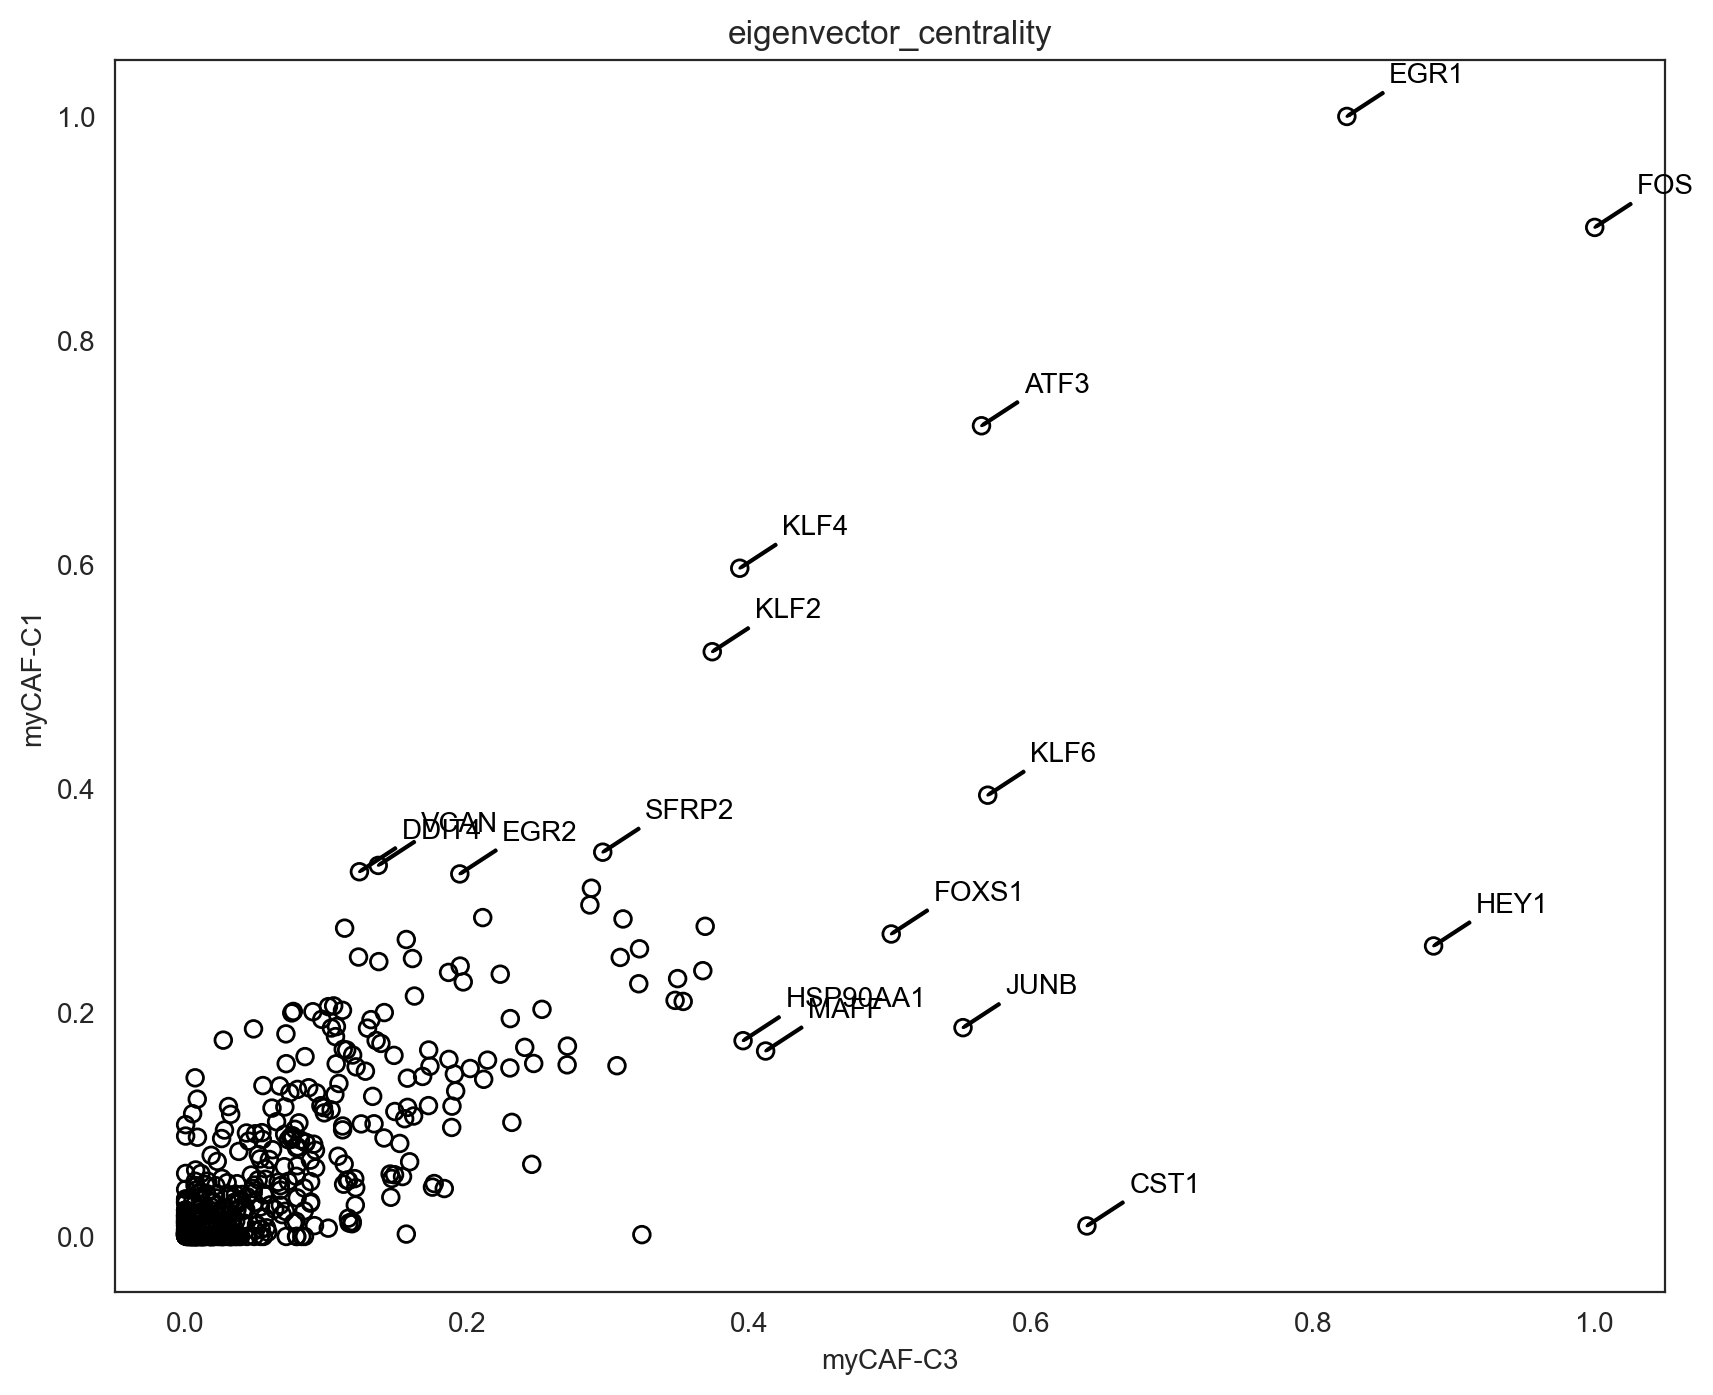

In [28]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="myCAF-C3", cluster2="myCAF-C1",
                               percentile=98,
                               save=f"{save_folder}/score_comparison")

In the following section, we focus on how a gene’s network score changes during the differentiation.

We will introduce how to visualize networks scores dynamics using Gata2 as an example.

SOX4


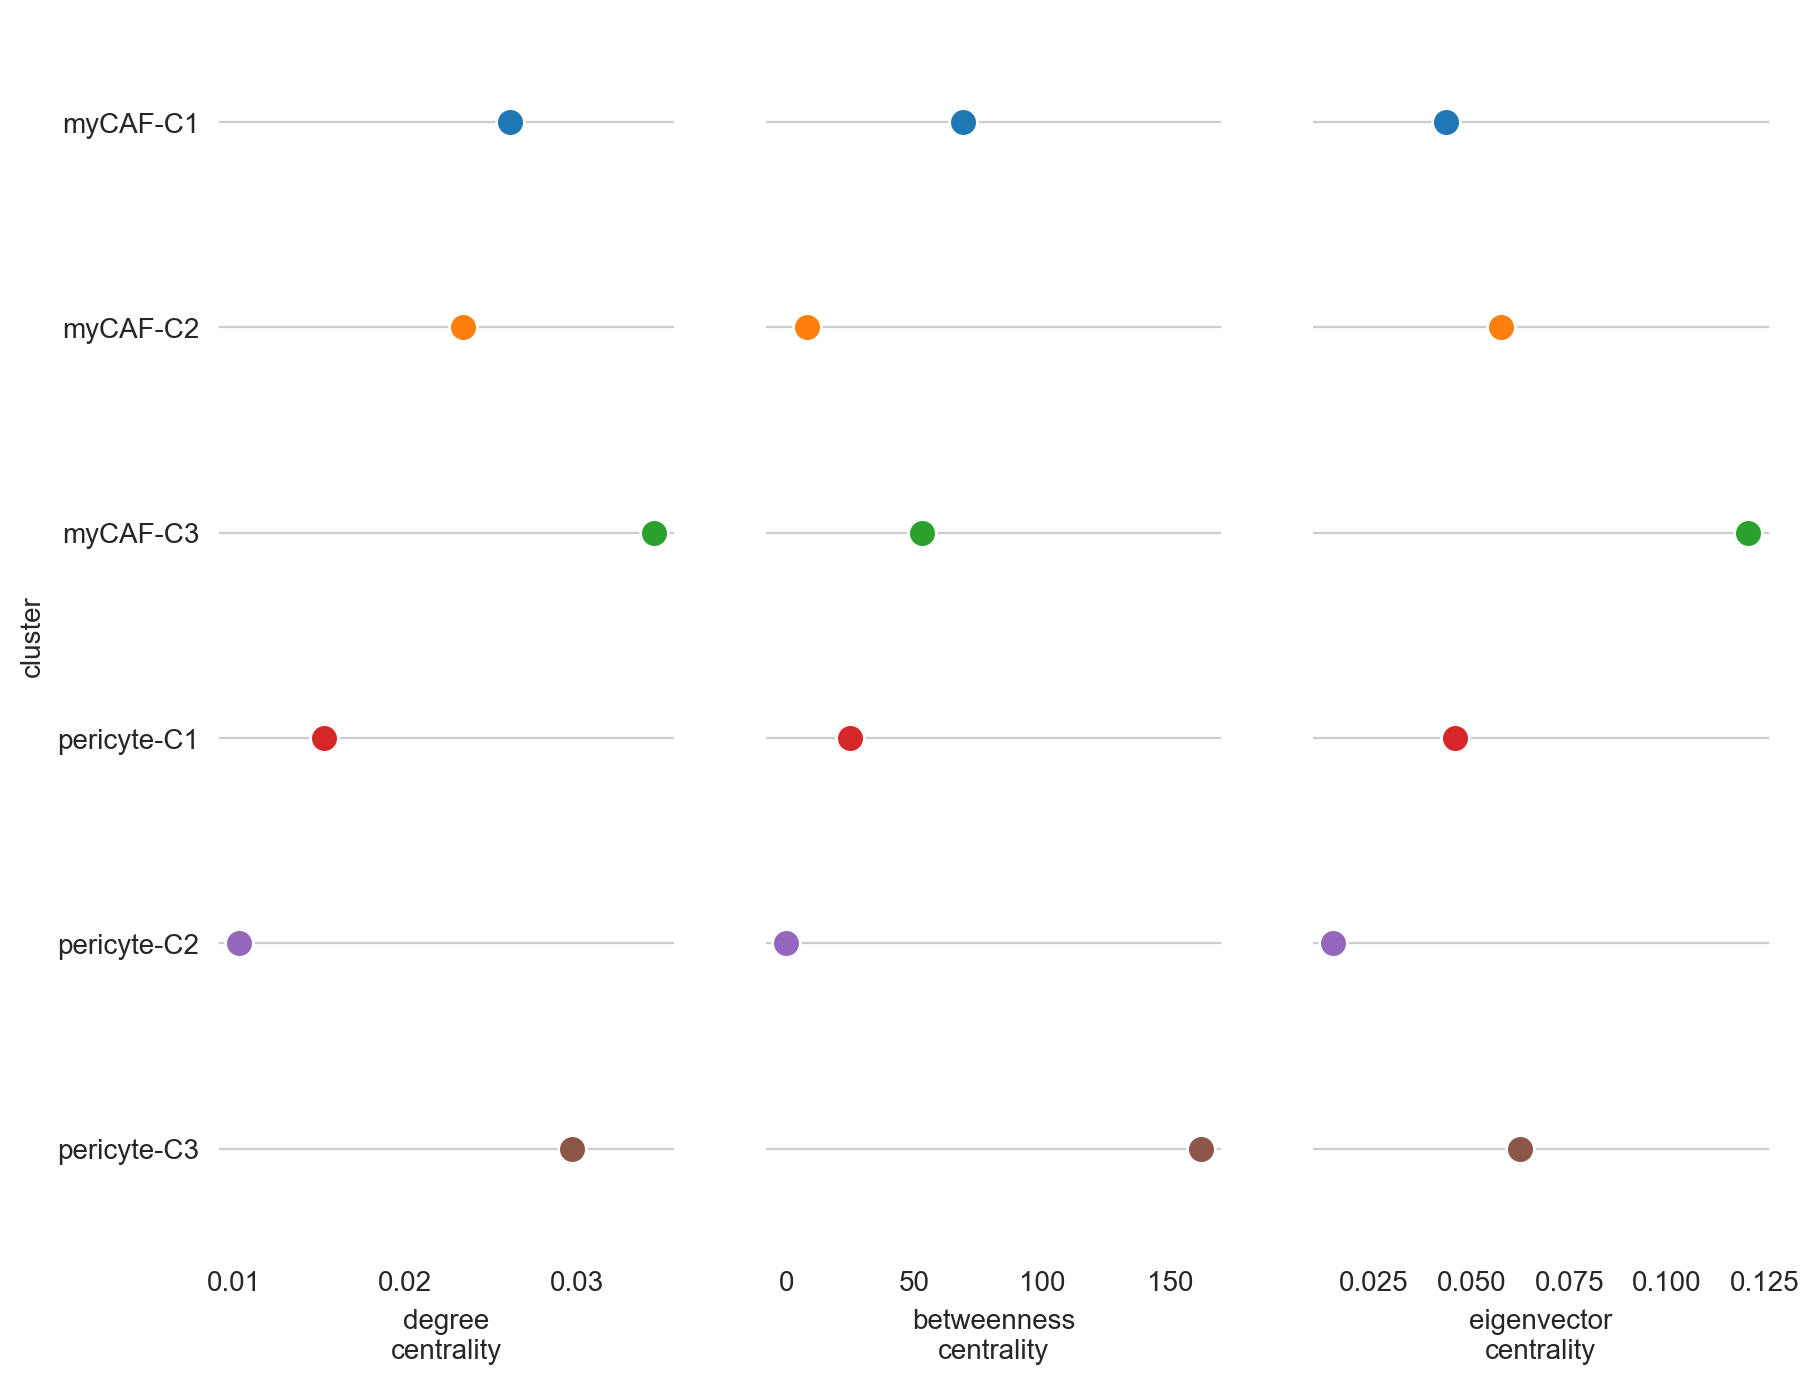

In [29]:
# Visualize Gata2 network score dynamics
links.plot_score_per_cluster(goi="SOX4", save=f"{save_folder}/network_score_per_gene/")

If a gene does not have network edge in a cluster, the network scores cannot be calculated and the scores will not be shown.

You can check the filtered network edge as follows.

In [30]:
cluster_name = "myCAF-C3"
filtered_links_df = links.filtered_links[cluster_name]
filtered_links_df.head()

,source,target,coef_mean,coef_abs,p,-logp
6049,HEY1,CST1,-1.517692,1.517692,2.176316e-20,19.662278
6066,NR4A3,CST1,-1.005172,1.005172,7.299272e-13,12.136720
9669,EGR1,FOS,0.997264,0.997264,8.048702e-17,16.094274
12356,FOS,HSPA1A,0.897120,0.897120,1.222078e-11,10.912901
6060,FOXS1,CST1,0.889756,0.889756,1.123186e-14,13.949548


# Network analysis; network score distribution

degree_centrality_all


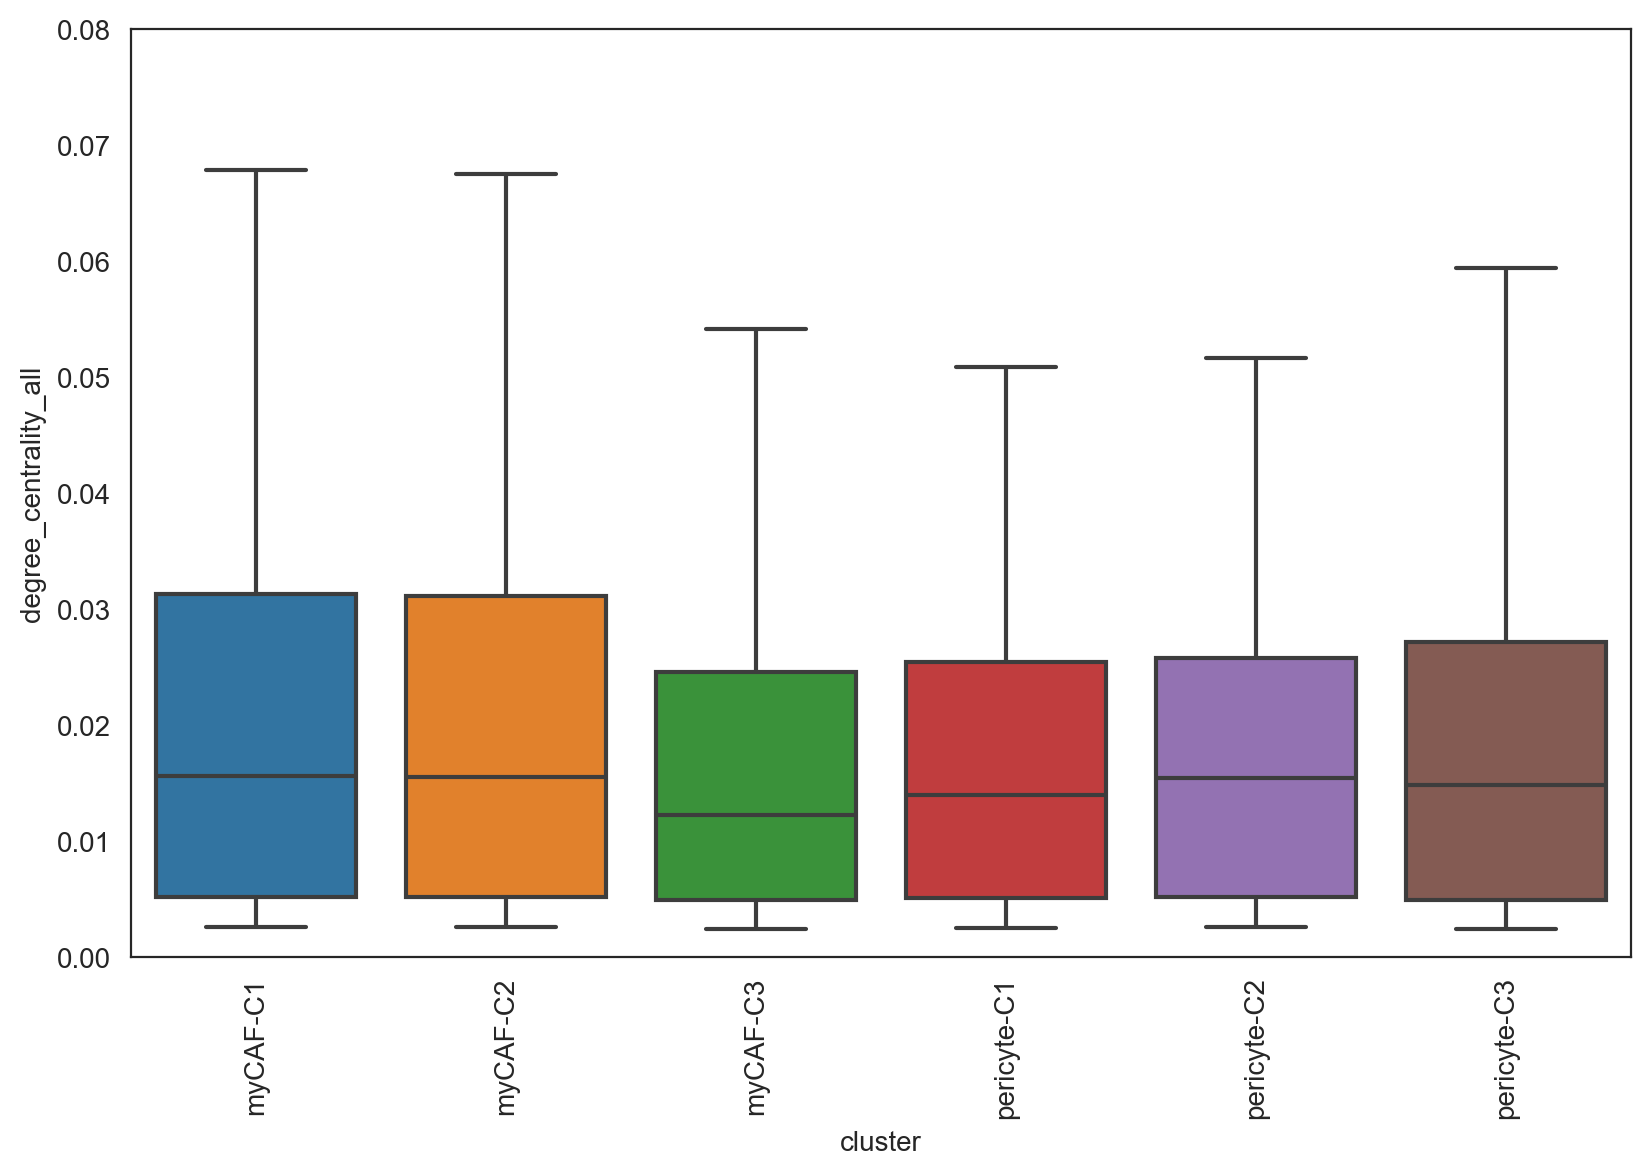

In [31]:
# Plot degree_centrality
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0,0.08])
links.plot_score_discributions(values=["degree_centrality_all"],
                               method="boxplot",
                               save=f"{save_folder}",
                              )

eigenvector_centrality


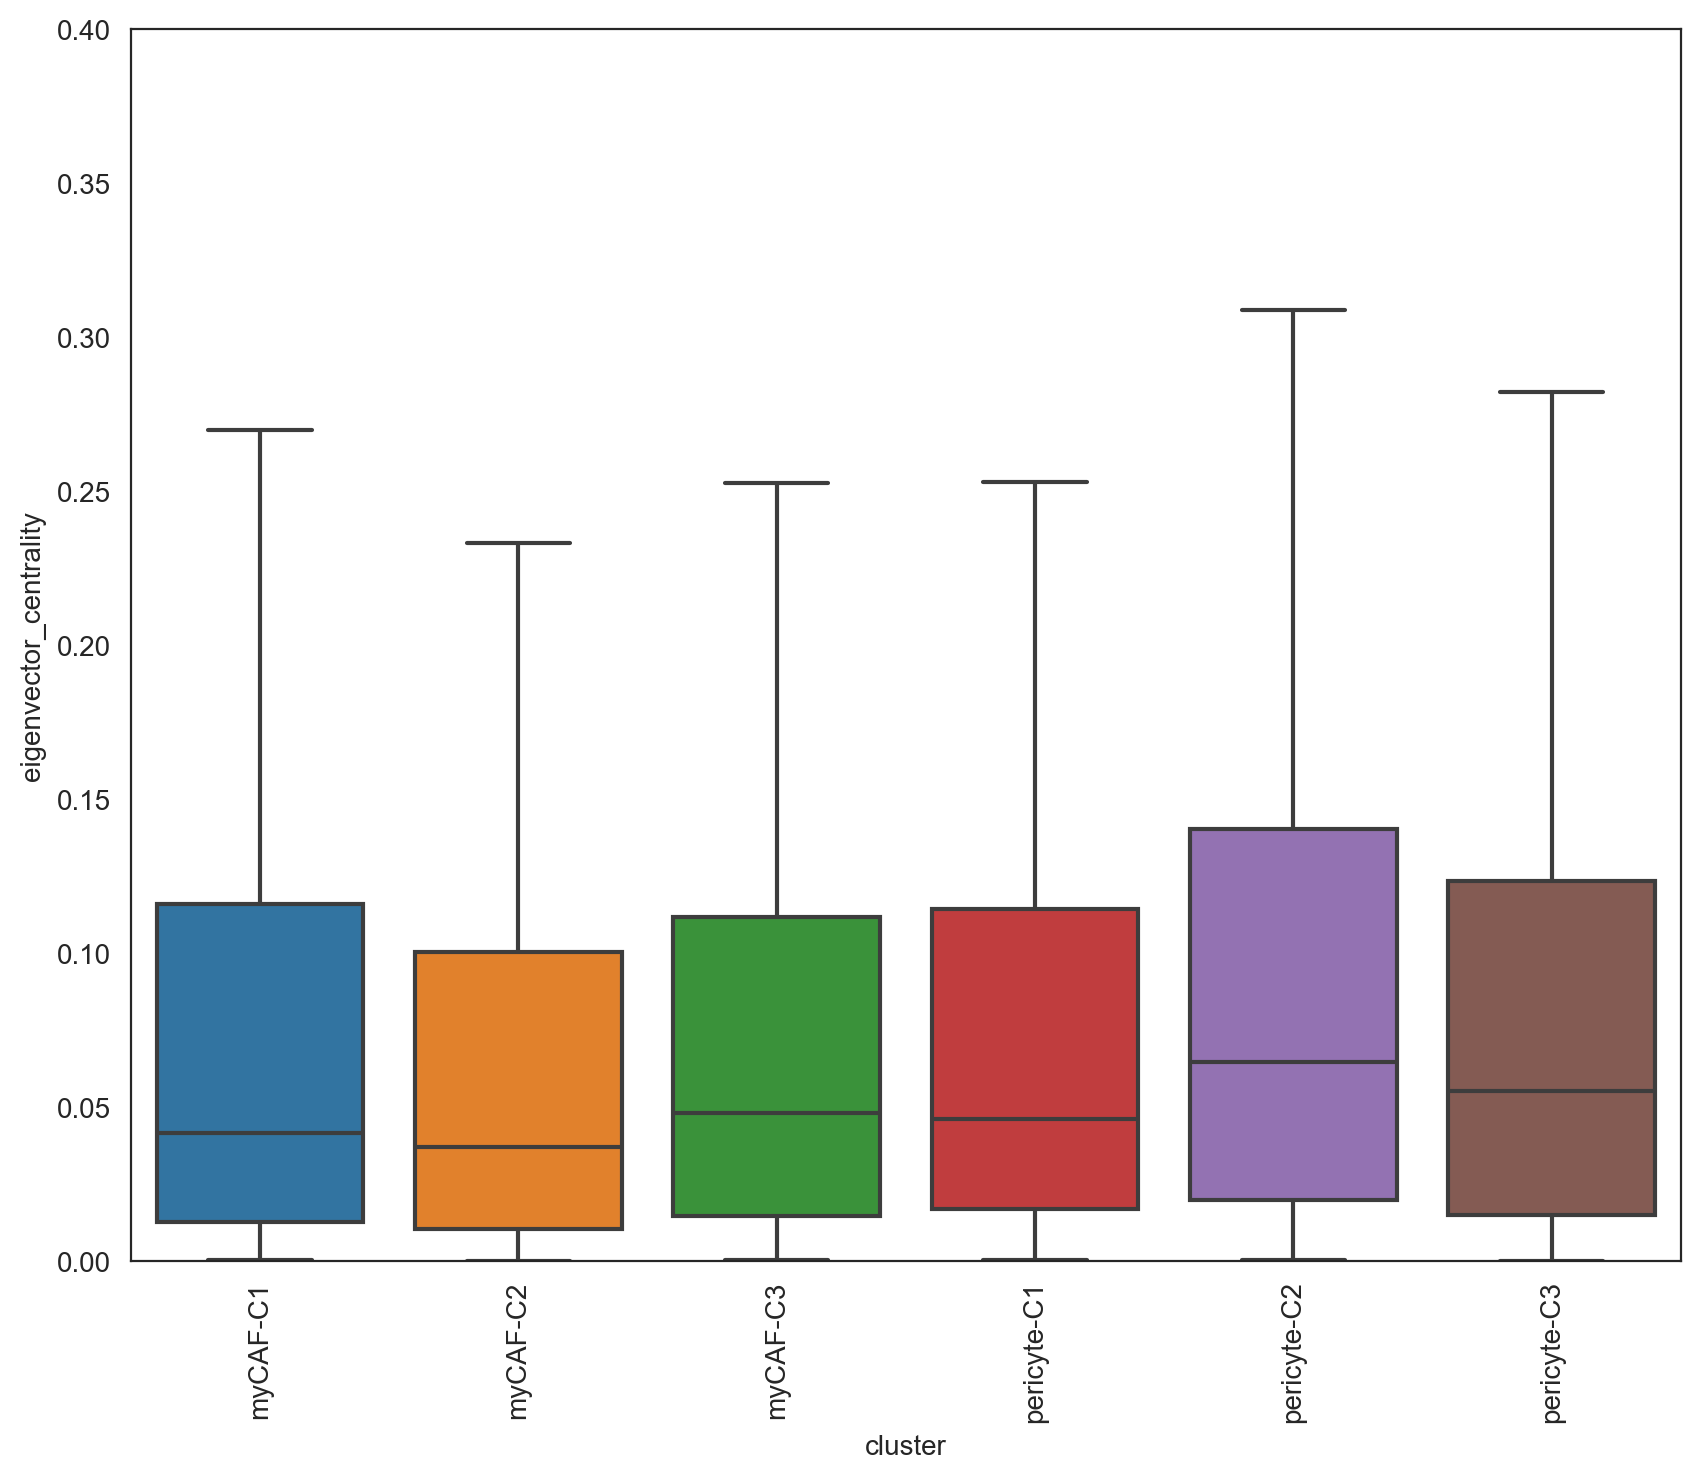

In [32]:
# Plot eigenvector_centrality
#plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0, 0.4])
links.plot_score_discributions(values=["eigenvector_centrality"],
                               method="boxplot",
                               save=f"{save_folder}")

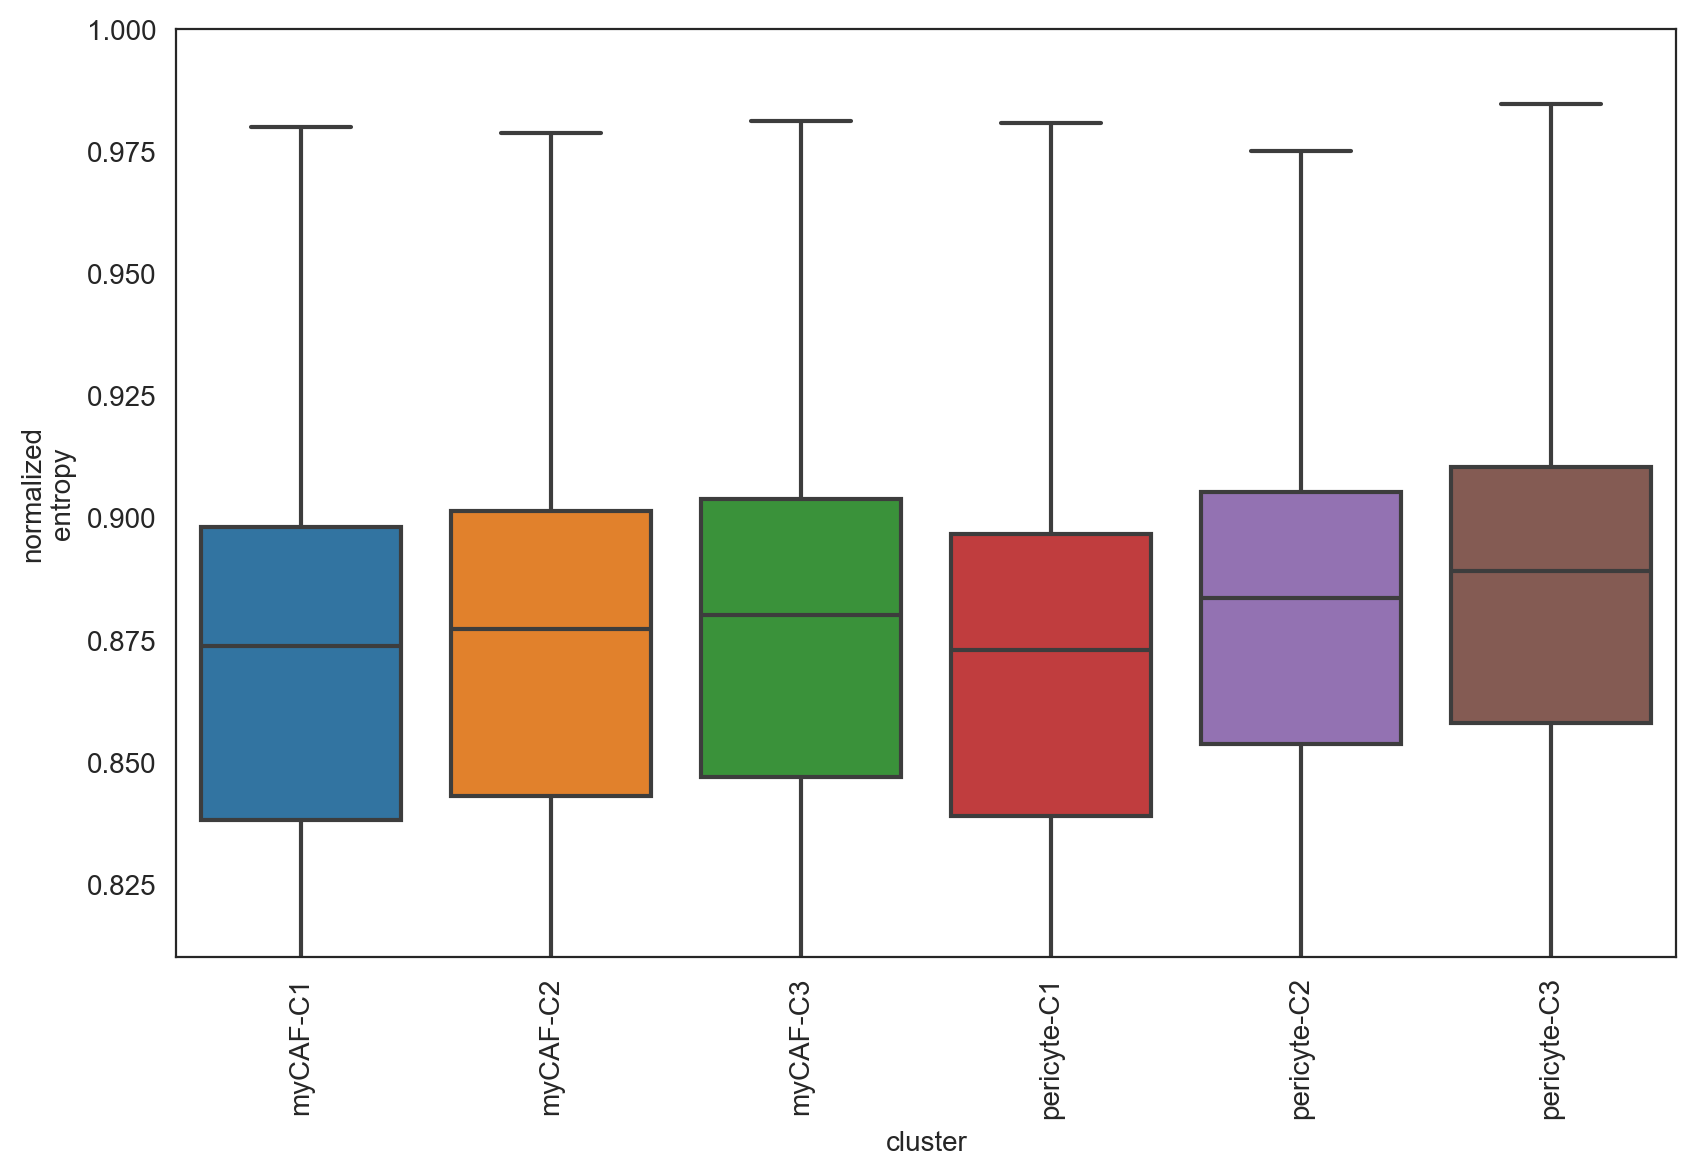

In [33]:
plt.subplots_adjust(left=0.15, bottom=0.3)
links.plot_network_entropy_distributions(save=f"{save_folder}")